## Poisson equation with variable coefficient
The Poisson equation on a unit disk with zero Dirichlet boundary condition can be written as $- \nabla \cdot (c\nabla  u) = 1$  in $\Omega$, $u=0$ on $\partial \Omega$ , where $\Omega$  is the unit disk. The exact solution when  is
$$
u(x,y)= \frac{1-x^2-y^2}{4}
$$


Here, objective is to compute the coefficient $c$ using PINN and we assume $c$ is scalar.

In [1]:
## Import the required modules
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

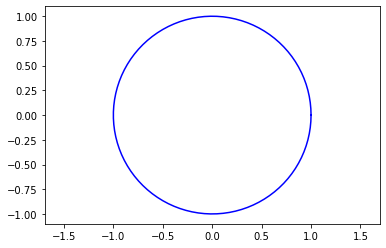

In [2]:
## Problem description
r = 1
theta = np.linspace(0, 2*np.pi, 100)
x = r*np.cos(theta)
y = r*np.sin(theta)
plt.plot(x, y, "-b", lw=1.5)
plt.axis("equal");

In [3]:
def generate_collocation_points(radius, num_samples):
    r = radius * np.sqrt(np.random.rand(num_samples, 1))
    theta = np.random.uniform(0, 2 * np.pi, num_samples)
    x = r * np.cos(theta).reshape(-1, 1)
    y = r * np.sin(theta).reshape(-1, 1)    
    xy = np.concatenate((x, y), axis=1)
    return xy

def generate_boundary_points(radius, num_samples):
    theta = np.linspace(0, 2 * np.pi, num_samples)
    x = r * np.cos(theta).reshape(-1, 1)
    y = r * np.sin(theta).reshape(-1, 1)
    xy = np.concatenate((x, y), axis=1)
    return xy

def analytical_sol(xy):
    u = (1/4.0)*(1 - xy[:, 0]*xy[:,0] - xy[:, 1]* xy[:, 1])
    u = u.reshape(-1, 1)
    return u


def generate_validation_data(radius, num_samples):
    r = radius * np.sqrt(np.random.rand(num_samples, 1))
    theta = np.random.uniform(0, 2 * np.pi, num_samples)
    x = r * np.cos(theta).reshape(-1, 1)
    y = r * np.sin(theta).reshape(-1, 1)
    xy = np.concatentae((x, y), axis=1)
    return xy
    



In [5]:
class PINN(nn.Module):
    def __init__(self, input_size, num_neurons, output_size):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_size, num_neurons)
        self.activation_1 = nn.Tanh()
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.activation_2 = nn.Tanh()
        self.fc3 = nn.Linear(num_neurons, output_size)
    

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation_1(x)
        x = self.fc2(x)
        x = self.activation_2(x)
        x = self.fc3(x)
        return x
    
    

def net_f(model, model_c, xy_f):    
    u = model(xy_f)
    c = model_c(xy_f)    
    grad_u = torch.autograd.grad(u, xy_f, grad_outputs=torch.ones_like(u),
                                 create_graph=True)[0]
    c = c.squeeze()
    u_xx = torch.autograd.grad(c*grad_u[:, 0], xy_f, grad_outputs=torch.ones_like(grad_u[:, 0]),
                               create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(c*grad_u[:, 1], xy_f, grad_outputs=torch.ones_like(grad_u[:, 1]),
                               create_graph=True)[0][:, 1]
    return u_xx + u_yy + 1.0

def net_d(model, x_d):
    u = model(x_d)
    return u

def loss_fn(model, model_c, xy_f, xy_d, u_d):
    f = net_f(model,model_c,xy_f)
    d = net_d(model, xy_d)
    loss_f = (f**2).mean() 
    loss_d = ((d - u_d)**2).mean()
    loss = loss_d + 0.01*loss_f
    return loss

    
    

In [6]:
if __name__=="__main__":
    r =1.0
    num_collocation_points = 1000
    num_boundary_points = 100
    num_data = 200
    
    # Initialize Collocation Points
    xy_f = torch.tensor(generate_collocation_points(r, num_collocation_points), requires_grad=True, 
                        dtype=torch.float32)
  
    
    # Initialize boundary points
    xy_b = torch.tensor(generate_boundary_points(r, num_boundary_points), dtype=torch.float32)
    u_b = torch.zeros((xy_b.size(0), 1), dtype=torch.float32)
    
    # Initialize data values
    xy_d = generate_collocation_points(r, num_data)
    u_d = analytical_sol(xy_d)
    xy_d = torch.tensor(xy_d, dtype=torch.float32)
    u_d = torch.tensor(u_d, dtype=torch.float32)
 
    # Concatenate boundary and interior data points
    xy_data = torch.concatenate((xy_b, xy_d), axis=0)
    u_data = torch.concatenate((u_b, u_d), axis=0)
    nIters = 15000
    d_in = 2
    num_neurons = 60
    d_out = 1
    lr = 1e-03
    model = PINN(d_in, num_neurons, d_out)
    model_c = PINN(d_in, num_neurons, d_out)
    optimizer = torch.optim.Adam(list(model.parameters()) + list(model_c.parameters()), lr = lr)
    loss_history = []
    c_history = np.zeros(shape=(nIters, 1))
        
    # Start Training    
    for it in range(0, nIters):
        optimizer.zero_grad()
        loss = loss_fn(model, model_c, xy_f, xy_d, u_d)
        loss.backward()
        optimizer.step()
        if it % 1 == 0:
            #c = model.get_parameter().detach().cpu().numpy()
            print(f"Epoch {it+1}/{nIters}, Loss: {loss:.8f}") 
            #c_history[it]= c
            #print(f"Type: {type(c)}")
            loss_history.append(loss.detach().cpu().numpy())

      


Epoch 1/15000, Loss: 0.02404919
Epoch 2/15000, Loss: 0.01591851
Epoch 3/15000, Loss: 0.01701578
Epoch 4/15000, Loss: 0.01831510
Epoch 5/15000, Loss: 0.01716749
Epoch 6/15000, Loss: 0.01567061
Epoch 7/15000, Loss: 0.01535004
Epoch 8/15000, Loss: 0.01600665
Epoch 9/15000, Loss: 0.01650088
Epoch 10/15000, Loss: 0.01619513
Epoch 11/15000, Loss: 0.01534873
Epoch 12/15000, Loss: 0.01459213
Epoch 13/15000, Loss: 0.01435314
Epoch 14/15000, Loss: 0.01457924
Epoch 15/15000, Loss: 0.01486086
Epoch 16/15000, Loss: 0.01483914
Epoch 17/15000, Loss: 0.01448823
Epoch 18/15000, Loss: 0.01404386
Epoch 19/15000, Loss: 0.01374833
Epoch 20/15000, Loss: 0.01365601
Epoch 21/15000, Loss: 0.01362629
Epoch 22/15000, Loss: 0.01348031
Epoch 23/15000, Loss: 0.01316302
Epoch 24/15000, Loss: 0.01276796
Epoch 25/15000, Loss: 0.01243242
Epoch 26/15000, Loss: 0.01221386
Epoch 27/15000, Loss: 0.01205019
Epoch 28/15000, Loss: 0.01182746
Epoch 29/15000, Loss: 0.01148419
Epoch 30/15000, Loss: 0.01105433
Epoch 31/15000, Los

Epoch 246/15000, Loss: 0.00026618
Epoch 247/15000, Loss: 0.00025786
Epoch 248/15000, Loss: 0.00024967
Epoch 249/15000, Loss: 0.00024159
Epoch 250/15000, Loss: 0.00023364
Epoch 251/15000, Loss: 0.00022580
Epoch 252/15000, Loss: 0.00021807
Epoch 253/15000, Loss: 0.00021046
Epoch 254/15000, Loss: 0.00020297
Epoch 255/15000, Loss: 0.00019560
Epoch 256/15000, Loss: 0.00018837
Epoch 257/15000, Loss: 0.00018126
Epoch 258/15000, Loss: 0.00017430
Epoch 259/15000, Loss: 0.00016748
Epoch 260/15000, Loss: 0.00016082
Epoch 261/15000, Loss: 0.00015432
Epoch 262/15000, Loss: 0.00014799
Epoch 263/15000, Loss: 0.00014184
Epoch 264/15000, Loss: 0.00013587
Epoch 265/15000, Loss: 0.00013010
Epoch 266/15000, Loss: 0.00012453
Epoch 267/15000, Loss: 0.00011917
Epoch 268/15000, Loss: 0.00011402
Epoch 269/15000, Loss: 0.00010910
Epoch 270/15000, Loss: 0.00010441
Epoch 271/15000, Loss: 0.00009995
Epoch 272/15000, Loss: 0.00009573
Epoch 273/15000, Loss: 0.00009175
Epoch 274/15000, Loss: 0.00008801
Epoch 275/1500

Epoch 493/15000, Loss: 0.00001565
Epoch 494/15000, Loss: 0.00001561
Epoch 495/15000, Loss: 0.00001557
Epoch 496/15000, Loss: 0.00001552
Epoch 497/15000, Loss: 0.00001548
Epoch 498/15000, Loss: 0.00001544
Epoch 499/15000, Loss: 0.00001540
Epoch 500/15000, Loss: 0.00001536
Epoch 501/15000, Loss: 0.00001532
Epoch 502/15000, Loss: 0.00001528
Epoch 503/15000, Loss: 0.00001525
Epoch 504/15000, Loss: 0.00001521
Epoch 505/15000, Loss: 0.00001518
Epoch 506/15000, Loss: 0.00001516
Epoch 507/15000, Loss: 0.00001515
Epoch 508/15000, Loss: 0.00001516
Epoch 509/15000, Loss: 0.00001522
Epoch 510/15000, Loss: 0.00001536
Epoch 511/15000, Loss: 0.00001563
Epoch 512/15000, Loss: 0.00001615
Epoch 513/15000, Loss: 0.00001705
Epoch 514/15000, Loss: 0.00001842
Epoch 515/15000, Loss: 0.00002006
Epoch 516/15000, Loss: 0.00002121
Epoch 517/15000, Loss: 0.00002071
Epoch 518/15000, Loss: 0.00001832
Epoch 519/15000, Loss: 0.00001561
Epoch 520/15000, Loss: 0.00001462
Epoch 521/15000, Loss: 0.00001565
Epoch 522/1500

Epoch 734/15000, Loss: 0.00002370
Epoch 735/15000, Loss: 0.00002622
Epoch 736/15000, Loss: 0.00002662
Epoch 737/15000, Loss: 0.00002399
Epoch 738/15000, Loss: 0.00001885
Epoch 739/15000, Loss: 0.00001353
Epoch 740/15000, Loss: 0.00001053
Epoch 741/15000, Loss: 0.00001081
Epoch 742/15000, Loss: 0.00001329
Epoch 743/15000, Loss: 0.00001591
Epoch 744/15000, Loss: 0.00001687
Epoch 745/15000, Loss: 0.00001560
Epoch 746/15000, Loss: 0.00001305
Epoch 747/15000, Loss: 0.00001086
Epoch 748/15000, Loss: 0.00001020
Epoch 749/15000, Loss: 0.00001105
Epoch 750/15000, Loss: 0.00001245
Epoch 751/15000, Loss: 0.00001328
Epoch 752/15000, Loss: 0.00001302
Epoch 753/15000, Loss: 0.00001191
Epoch 754/15000, Loss: 0.00001072
Epoch 755/15000, Loss: 0.00001013
Epoch 756/15000, Loss: 0.00001031
Epoch 757/15000, Loss: 0.00001094
Epoch 758/15000, Loss: 0.00001149
Epoch 759/15000, Loss: 0.00001159
Epoch 760/15000, Loss: 0.00001121
Epoch 761/15000, Loss: 0.00001062
Epoch 762/15000, Loss: 0.00001016
Epoch 763/1500

Epoch 988/15000, Loss: 0.00000924
Epoch 989/15000, Loss: 0.00000948
Epoch 990/15000, Loss: 0.00000926
Epoch 991/15000, Loss: 0.00000876
Epoch 992/15000, Loss: 0.00000831
Epoch 993/15000, Loss: 0.00000813
Epoch 994/15000, Loss: 0.00000825
Epoch 995/15000, Loss: 0.00000851
Epoch 996/15000, Loss: 0.00000871
Epoch 997/15000, Loss: 0.00000873
Epoch 998/15000, Loss: 0.00000857
Epoch 999/15000, Loss: 0.00000834
Epoch 1000/15000, Loss: 0.00000815
Epoch 1001/15000, Loss: 0.00000808
Epoch 1002/15000, Loss: 0.00000813
Epoch 1003/15000, Loss: 0.00000824
Epoch 1004/15000, Loss: 0.00000833
Epoch 1005/15000, Loss: 0.00000835
Epoch 1006/15000, Loss: 0.00000829
Epoch 1007/15000, Loss: 0.00000820
Epoch 1008/15000, Loss: 0.00000810
Epoch 1009/15000, Loss: 0.00000804
Epoch 1010/15000, Loss: 0.00000803
Epoch 1011/15000, Loss: 0.00000805
Epoch 1012/15000, Loss: 0.00000809
Epoch 1013/15000, Loss: 0.00000812
Epoch 1014/15000, Loss: 0.00000813
Epoch 1015/15000, Loss: 0.00000811
Epoch 1016/15000, Loss: 0.000008

Epoch 1225/15000, Loss: 0.00000690
Epoch 1226/15000, Loss: 0.00000691
Epoch 1227/15000, Loss: 0.00000692
Epoch 1228/15000, Loss: 0.00000696
Epoch 1229/15000, Loss: 0.00000702
Epoch 1230/15000, Loss: 0.00000714
Epoch 1231/15000, Loss: 0.00000735
Epoch 1232/15000, Loss: 0.00000774
Epoch 1233/15000, Loss: 0.00000846
Epoch 1234/15000, Loss: 0.00000980
Epoch 1235/15000, Loss: 0.00001227
Epoch 1236/15000, Loss: 0.00001684
Epoch 1237/15000, Loss: 0.00002525
Epoch 1238/15000, Loss: 0.00004042
Epoch 1239/15000, Loss: 0.00006677
Epoch 1240/15000, Loss: 0.00010852
Epoch 1241/15000, Loss: 0.00016462
Epoch 1242/15000, Loss: 0.00021484
Epoch 1243/15000, Loss: 0.00021829
Epoch 1244/15000, Loss: 0.00014673
Epoch 1245/15000, Loss: 0.00004730
Epoch 1246/15000, Loss: 0.00000697
Epoch 1247/15000, Loss: 0.00004740
Epoch 1248/15000, Loss: 0.00010225
Epoch 1249/15000, Loss: 0.00009842
Epoch 1250/15000, Loss: 0.00004221
Epoch 1251/15000, Loss: 0.00000701
Epoch 1252/15000, Loss: 0.00002902
Epoch 1253/15000, Lo

Epoch 1473/15000, Loss: 0.00000594
Epoch 1474/15000, Loss: 0.00000593
Epoch 1475/15000, Loss: 0.00000593
Epoch 1476/15000, Loss: 0.00000593
Epoch 1477/15000, Loss: 0.00000592
Epoch 1478/15000, Loss: 0.00000592
Epoch 1479/15000, Loss: 0.00000591
Epoch 1480/15000, Loss: 0.00000591
Epoch 1481/15000, Loss: 0.00000591
Epoch 1482/15000, Loss: 0.00000590
Epoch 1483/15000, Loss: 0.00000590
Epoch 1484/15000, Loss: 0.00000590
Epoch 1485/15000, Loss: 0.00000589
Epoch 1486/15000, Loss: 0.00000589
Epoch 1487/15000, Loss: 0.00000589
Epoch 1488/15000, Loss: 0.00000588
Epoch 1489/15000, Loss: 0.00000588
Epoch 1490/15000, Loss: 0.00000588
Epoch 1491/15000, Loss: 0.00000588
Epoch 1492/15000, Loss: 0.00000588
Epoch 1493/15000, Loss: 0.00000588
Epoch 1494/15000, Loss: 0.00000589
Epoch 1495/15000, Loss: 0.00000590
Epoch 1496/15000, Loss: 0.00000594
Epoch 1497/15000, Loss: 0.00000600
Epoch 1498/15000, Loss: 0.00000611
Epoch 1499/15000, Loss: 0.00000631
Epoch 1500/15000, Loss: 0.00000669
Epoch 1501/15000, Lo

Epoch 1720/15000, Loss: 0.00000521
Epoch 1721/15000, Loss: 0.00000520
Epoch 1722/15000, Loss: 0.00000520
Epoch 1723/15000, Loss: 0.00000520
Epoch 1724/15000, Loss: 0.00000519
Epoch 1725/15000, Loss: 0.00000519
Epoch 1726/15000, Loss: 0.00000519
Epoch 1727/15000, Loss: 0.00000518
Epoch 1728/15000, Loss: 0.00000518
Epoch 1729/15000, Loss: 0.00000518
Epoch 1730/15000, Loss: 0.00000518
Epoch 1731/15000, Loss: 0.00000517
Epoch 1732/15000, Loss: 0.00000517
Epoch 1733/15000, Loss: 0.00000517
Epoch 1734/15000, Loss: 0.00000516
Epoch 1735/15000, Loss: 0.00000516
Epoch 1736/15000, Loss: 0.00000516
Epoch 1737/15000, Loss: 0.00000515
Epoch 1738/15000, Loss: 0.00000515
Epoch 1739/15000, Loss: 0.00000515
Epoch 1740/15000, Loss: 0.00000515
Epoch 1741/15000, Loss: 0.00000514
Epoch 1742/15000, Loss: 0.00000514
Epoch 1743/15000, Loss: 0.00000514
Epoch 1744/15000, Loss: 0.00000513
Epoch 1745/15000, Loss: 0.00000513
Epoch 1746/15000, Loss: 0.00000513
Epoch 1747/15000, Loss: 0.00000512
Epoch 1748/15000, Lo

Epoch 1960/15000, Loss: 0.00000466
Epoch 1961/15000, Loss: 0.00000466
Epoch 1962/15000, Loss: 0.00000465
Epoch 1963/15000, Loss: 0.00000465
Epoch 1964/15000, Loss: 0.00000465
Epoch 1965/15000, Loss: 0.00000465
Epoch 1966/15000, Loss: 0.00000465
Epoch 1967/15000, Loss: 0.00000464
Epoch 1968/15000, Loss: 0.00000464
Epoch 1969/15000, Loss: 0.00000464
Epoch 1970/15000, Loss: 0.00000464
Epoch 1971/15000, Loss: 0.00000463
Epoch 1972/15000, Loss: 0.00000463
Epoch 1973/15000, Loss: 0.00000463
Epoch 1974/15000, Loss: 0.00000463
Epoch 1975/15000, Loss: 0.00000462
Epoch 1976/15000, Loss: 0.00000462
Epoch 1977/15000, Loss: 0.00000462
Epoch 1978/15000, Loss: 0.00000462
Epoch 1979/15000, Loss: 0.00000461
Epoch 1980/15000, Loss: 0.00000461
Epoch 1981/15000, Loss: 0.00000461
Epoch 1982/15000, Loss: 0.00000461
Epoch 1983/15000, Loss: 0.00000460
Epoch 1984/15000, Loss: 0.00000460
Epoch 1985/15000, Loss: 0.00000460
Epoch 1986/15000, Loss: 0.00000460
Epoch 1987/15000, Loss: 0.00000459
Epoch 1988/15000, Lo

Epoch 2204/15000, Loss: 0.00000409
Epoch 2205/15000, Loss: 0.00000409
Epoch 2206/15000, Loss: 0.00000409
Epoch 2207/15000, Loss: 0.00000408
Epoch 2208/15000, Loss: 0.00000408
Epoch 2209/15000, Loss: 0.00000408
Epoch 2210/15000, Loss: 0.00000408
Epoch 2211/15000, Loss: 0.00000408
Epoch 2212/15000, Loss: 0.00000407
Epoch 2213/15000, Loss: 0.00000407
Epoch 2214/15000, Loss: 0.00000407
Epoch 2215/15000, Loss: 0.00000407
Epoch 2216/15000, Loss: 0.00000406
Epoch 2217/15000, Loss: 0.00000406
Epoch 2218/15000, Loss: 0.00000406
Epoch 2219/15000, Loss: 0.00000406
Epoch 2220/15000, Loss: 0.00000406
Epoch 2221/15000, Loss: 0.00000405
Epoch 2222/15000, Loss: 0.00000405
Epoch 2223/15000, Loss: 0.00000405
Epoch 2224/15000, Loss: 0.00000405
Epoch 2225/15000, Loss: 0.00000404
Epoch 2226/15000, Loss: 0.00000404
Epoch 2227/15000, Loss: 0.00000404
Epoch 2228/15000, Loss: 0.00000404
Epoch 2229/15000, Loss: 0.00000404
Epoch 2230/15000, Loss: 0.00000403
Epoch 2231/15000, Loss: 0.00000403
Epoch 2232/15000, Lo

Epoch 2448/15000, Loss: 0.00000365
Epoch 2449/15000, Loss: 0.00000365
Epoch 2450/15000, Loss: 0.00000364
Epoch 2451/15000, Loss: 0.00000364
Epoch 2452/15000, Loss: 0.00000364
Epoch 2453/15000, Loss: 0.00000364
Epoch 2454/15000, Loss: 0.00000364
Epoch 2455/15000, Loss: 0.00000363
Epoch 2456/15000, Loss: 0.00000363
Epoch 2457/15000, Loss: 0.00000363
Epoch 2458/15000, Loss: 0.00000363
Epoch 2459/15000, Loss: 0.00000363
Epoch 2460/15000, Loss: 0.00000362
Epoch 2461/15000, Loss: 0.00000362
Epoch 2462/15000, Loss: 0.00000362
Epoch 2463/15000, Loss: 0.00000362
Epoch 2464/15000, Loss: 0.00000362
Epoch 2465/15000, Loss: 0.00000361
Epoch 2466/15000, Loss: 0.00000361
Epoch 2467/15000, Loss: 0.00000361
Epoch 2468/15000, Loss: 0.00000361
Epoch 2469/15000, Loss: 0.00000361
Epoch 2470/15000, Loss: 0.00000361
Epoch 2471/15000, Loss: 0.00000360
Epoch 2472/15000, Loss: 0.00000360
Epoch 2473/15000, Loss: 0.00000360
Epoch 2474/15000, Loss: 0.00000360
Epoch 2475/15000, Loss: 0.00000360
Epoch 2476/15000, Lo

Epoch 2690/15000, Loss: 0.00000326
Epoch 2691/15000, Loss: 0.00000326
Epoch 2692/15000, Loss: 0.00000326
Epoch 2693/15000, Loss: 0.00000326
Epoch 2694/15000, Loss: 0.00000326
Epoch 2695/15000, Loss: 0.00000325
Epoch 2696/15000, Loss: 0.00000325
Epoch 2697/15000, Loss: 0.00000325
Epoch 2698/15000, Loss: 0.00000325
Epoch 2699/15000, Loss: 0.00000325
Epoch 2700/15000, Loss: 0.00000324
Epoch 2701/15000, Loss: 0.00000324
Epoch 2702/15000, Loss: 0.00000324
Epoch 2703/15000, Loss: 0.00000324
Epoch 2704/15000, Loss: 0.00000324
Epoch 2705/15000, Loss: 0.00000324
Epoch 2706/15000, Loss: 0.00000323
Epoch 2707/15000, Loss: 0.00000323
Epoch 2708/15000, Loss: 0.00000323
Epoch 2709/15000, Loss: 0.00000323
Epoch 2710/15000, Loss: 0.00000323
Epoch 2711/15000, Loss: 0.00000323
Epoch 2712/15000, Loss: 0.00000322
Epoch 2713/15000, Loss: 0.00000322
Epoch 2714/15000, Loss: 0.00000322
Epoch 2715/15000, Loss: 0.00000322
Epoch 2716/15000, Loss: 0.00000322
Epoch 2717/15000, Loss: 0.00000322
Epoch 2718/15000, Lo

Epoch 2934/15000, Loss: 0.00000473
Epoch 2935/15000, Loss: 0.00000353
Epoch 2936/15000, Loss: 0.00000291
Epoch 2937/15000, Loss: 0.00000350
Epoch 2938/15000, Loss: 0.00000415
Epoch 2939/15000, Loss: 0.00000384
Epoch 2940/15000, Loss: 0.00000310
Epoch 2941/15000, Loss: 0.00000294
Epoch 2942/15000, Loss: 0.00000340
Epoch 2943/15000, Loss: 0.00000367
Epoch 2944/15000, Loss: 0.00000336
Epoch 2945/15000, Loss: 0.00000295
Epoch 2946/15000, Loss: 0.00000296
Epoch 2947/15000, Loss: 0.00000326
Epoch 2948/15000, Loss: 0.00000335
Epoch 2949/15000, Loss: 0.00000312
Epoch 2950/15000, Loss: 0.00000290
Epoch 2951/15000, Loss: 0.00000296
Epoch 2952/15000, Loss: 0.00000313
Epoch 2953/15000, Loss: 0.00000315
Epoch 2954/15000, Loss: 0.00000300
Epoch 2955/15000, Loss: 0.00000288
Epoch 2956/15000, Loss: 0.00000293
Epoch 2957/15000, Loss: 0.00000303
Epoch 2958/15000, Loss: 0.00000303
Epoch 2959/15000, Loss: 0.00000294
Epoch 2960/15000, Loss: 0.00000288
Epoch 2961/15000, Loss: 0.00000291
Epoch 2962/15000, Lo

Epoch 3178/15000, Loss: 0.00000256
Epoch 3179/15000, Loss: 0.00000256
Epoch 3180/15000, Loss: 0.00000256
Epoch 3181/15000, Loss: 0.00000256
Epoch 3182/15000, Loss: 0.00000256
Epoch 3183/15000, Loss: 0.00000256
Epoch 3184/15000, Loss: 0.00000256
Epoch 3185/15000, Loss: 0.00000257
Epoch 3186/15000, Loss: 0.00000258
Epoch 3187/15000, Loss: 0.00000260
Epoch 3188/15000, Loss: 0.00000264
Epoch 3189/15000, Loss: 0.00000269
Epoch 3190/15000, Loss: 0.00000279
Epoch 3191/15000, Loss: 0.00000295
Epoch 3192/15000, Loss: 0.00000324
Epoch 3193/15000, Loss: 0.00000372
Epoch 3194/15000, Loss: 0.00000456
Epoch 3195/15000, Loss: 0.00000601
Epoch 3196/15000, Loss: 0.00000852
Epoch 3197/15000, Loss: 0.00001290
Epoch 3198/15000, Loss: 0.00002050
Epoch 3199/15000, Loss: 0.00003353
Epoch 3200/15000, Loss: 0.00005538
Epoch 3201/15000, Loss: 0.00009030
Epoch 3202/15000, Loss: 0.00014149
Epoch 3203/15000, Loss: 0.00020438
Epoch 3204/15000, Loss: 0.00025693
Epoch 3205/15000, Loss: 0.00025759
Epoch 3206/15000, Lo

Epoch 3417/15000, Loss: 0.00000229
Epoch 3418/15000, Loss: 0.00000229
Epoch 3419/15000, Loss: 0.00000229
Epoch 3420/15000, Loss: 0.00000229
Epoch 3421/15000, Loss: 0.00000229
Epoch 3422/15000, Loss: 0.00000229
Epoch 3423/15000, Loss: 0.00000229
Epoch 3424/15000, Loss: 0.00000228
Epoch 3425/15000, Loss: 0.00000228
Epoch 3426/15000, Loss: 0.00000228
Epoch 3427/15000, Loss: 0.00000228
Epoch 3428/15000, Loss: 0.00000228
Epoch 3429/15000, Loss: 0.00000228
Epoch 3430/15000, Loss: 0.00000228
Epoch 3431/15000, Loss: 0.00000228
Epoch 3432/15000, Loss: 0.00000227
Epoch 3433/15000, Loss: 0.00000227
Epoch 3434/15000, Loss: 0.00000227
Epoch 3435/15000, Loss: 0.00000227
Epoch 3436/15000, Loss: 0.00000227
Epoch 3437/15000, Loss: 0.00000227
Epoch 3438/15000, Loss: 0.00000227
Epoch 3439/15000, Loss: 0.00000227
Epoch 3440/15000, Loss: 0.00000226
Epoch 3441/15000, Loss: 0.00000226
Epoch 3442/15000, Loss: 0.00000226
Epoch 3443/15000, Loss: 0.00000226
Epoch 3444/15000, Loss: 0.00000226
Epoch 3445/15000, Lo

Epoch 3662/15000, Loss: 0.00000205
Epoch 3663/15000, Loss: 0.00000205
Epoch 3664/15000, Loss: 0.00000204
Epoch 3665/15000, Loss: 0.00000204
Epoch 3666/15000, Loss: 0.00000204
Epoch 3667/15000, Loss: 0.00000204
Epoch 3668/15000, Loss: 0.00000204
Epoch 3669/15000, Loss: 0.00000204
Epoch 3670/15000, Loss: 0.00000204
Epoch 3671/15000, Loss: 0.00000204
Epoch 3672/15000, Loss: 0.00000204
Epoch 3673/15000, Loss: 0.00000203
Epoch 3674/15000, Loss: 0.00000203
Epoch 3675/15000, Loss: 0.00000203
Epoch 3676/15000, Loss: 0.00000203
Epoch 3677/15000, Loss: 0.00000203
Epoch 3678/15000, Loss: 0.00000203
Epoch 3679/15000, Loss: 0.00000203
Epoch 3680/15000, Loss: 0.00000203
Epoch 3681/15000, Loss: 0.00000203
Epoch 3682/15000, Loss: 0.00000202
Epoch 3683/15000, Loss: 0.00000202
Epoch 3684/15000, Loss: 0.00000202
Epoch 3685/15000, Loss: 0.00000202
Epoch 3686/15000, Loss: 0.00000202
Epoch 3687/15000, Loss: 0.00000202
Epoch 3688/15000, Loss: 0.00000202
Epoch 3689/15000, Loss: 0.00000202
Epoch 3690/15000, Lo

Epoch 3907/15000, Loss: 0.00002902
Epoch 3908/15000, Loss: 0.00000612
Epoch 3909/15000, Loss: 0.00000458
Epoch 3910/15000, Loss: 0.00002023
Epoch 3911/15000, Loss: 0.00002465
Epoch 3912/15000, Loss: 0.00001146
Epoch 3913/15000, Loss: 0.00000186
Epoch 3914/15000, Loss: 0.00000795
Epoch 3915/15000, Loss: 0.00001624
Epoch 3916/15000, Loss: 0.00001261
Epoch 3917/15000, Loss: 0.00000362
Epoch 3918/15000, Loss: 0.00000282
Epoch 3919/15000, Loss: 0.00000894
Epoch 3920/15000, Loss: 0.00001061
Epoch 3921/15000, Loss: 0.00000540
Epoch 3922/15000, Loss: 0.00000181
Epoch 3923/15000, Loss: 0.00000435
Epoch 3924/15000, Loss: 0.00000748
Epoch 3925/15000, Loss: 0.00000589
Epoch 3926/15000, Loss: 0.00000242
Epoch 3927/15000, Loss: 0.00000226
Epoch 3928/15000, Loss: 0.00000466
Epoch 3929/15000, Loss: 0.00000522
Epoch 3930/15000, Loss: 0.00000315
Epoch 3931/15000, Loss: 0.00000179
Epoch 3932/15000, Loss: 0.00000280
Epoch 3933/15000, Loss: 0.00000402
Epoch 3934/15000, Loss: 0.00000340
Epoch 3935/15000, Lo

Epoch 4152/15000, Loss: 0.00000157
Epoch 4153/15000, Loss: 0.00000157
Epoch 4154/15000, Loss: 0.00000157
Epoch 4155/15000, Loss: 0.00000157
Epoch 4156/15000, Loss: 0.00000157
Epoch 4157/15000, Loss: 0.00000157
Epoch 4158/15000, Loss: 0.00000157
Epoch 4159/15000, Loss: 0.00000157
Epoch 4160/15000, Loss: 0.00000157
Epoch 4161/15000, Loss: 0.00000157
Epoch 4162/15000, Loss: 0.00000156
Epoch 4163/15000, Loss: 0.00000156
Epoch 4164/15000, Loss: 0.00000156
Epoch 4165/15000, Loss: 0.00000156
Epoch 4166/15000, Loss: 0.00000156
Epoch 4167/15000, Loss: 0.00000156
Epoch 4168/15000, Loss: 0.00000156
Epoch 4169/15000, Loss: 0.00000156
Epoch 4170/15000, Loss: 0.00000156
Epoch 4171/15000, Loss: 0.00000156
Epoch 4172/15000, Loss: 0.00000156
Epoch 4173/15000, Loss: 0.00000155
Epoch 4174/15000, Loss: 0.00000155
Epoch 4175/15000, Loss: 0.00000155
Epoch 4176/15000, Loss: 0.00000155
Epoch 4177/15000, Loss: 0.00000155
Epoch 4178/15000, Loss: 0.00000155
Epoch 4179/15000, Loss: 0.00000155
Epoch 4180/15000, Lo

Epoch 4393/15000, Loss: 0.00000139
Epoch 4394/15000, Loss: 0.00000139
Epoch 4395/15000, Loss: 0.00000139
Epoch 4396/15000, Loss: 0.00000139
Epoch 4397/15000, Loss: 0.00000139
Epoch 4398/15000, Loss: 0.00000139
Epoch 4399/15000, Loss: 0.00000139
Epoch 4400/15000, Loss: 0.00000139
Epoch 4401/15000, Loss: 0.00000138
Epoch 4402/15000, Loss: 0.00000138
Epoch 4403/15000, Loss: 0.00000138
Epoch 4404/15000, Loss: 0.00000138
Epoch 4405/15000, Loss: 0.00000138
Epoch 4406/15000, Loss: 0.00000138
Epoch 4407/15000, Loss: 0.00000138
Epoch 4408/15000, Loss: 0.00000138
Epoch 4409/15000, Loss: 0.00000138
Epoch 4410/15000, Loss: 0.00000138
Epoch 4411/15000, Loss: 0.00000138
Epoch 4412/15000, Loss: 0.00000138
Epoch 4413/15000, Loss: 0.00000137
Epoch 4414/15000, Loss: 0.00000137
Epoch 4415/15000, Loss: 0.00000137
Epoch 4416/15000, Loss: 0.00000137
Epoch 4417/15000, Loss: 0.00000137
Epoch 4418/15000, Loss: 0.00000137
Epoch 4419/15000, Loss: 0.00000137
Epoch 4420/15000, Loss: 0.00000137
Epoch 4421/15000, Lo

Epoch 4635/15000, Loss: 0.00003325
Epoch 4636/15000, Loss: 0.00001163
Epoch 4637/15000, Loss: 0.00000136
Epoch 4638/15000, Loss: 0.00001294
Epoch 4639/15000, Loss: 0.00002327
Epoch 4640/15000, Loss: 0.00001552
Epoch 4641/15000, Loss: 0.00000288
Epoch 4642/15000, Loss: 0.00000354
Epoch 4643/15000, Loss: 0.00001265
Epoch 4644/15000, Loss: 0.00001382
Epoch 4645/15000, Loss: 0.00000569
Epoch 4646/15000, Loss: 0.00000123
Epoch 4647/15000, Loss: 0.00000555
Epoch 4648/15000, Loss: 0.00000971
Epoch 4649/15000, Loss: 0.00000677
Epoch 4650/15000, Loss: 0.00000185
Epoch 4651/15000, Loss: 0.00000214
Epoch 4652/15000, Loss: 0.00000570
Epoch 4653/15000, Loss: 0.00000609
Epoch 4654/15000, Loss: 0.00000290
Epoch 4655/15000, Loss: 0.00000121
Epoch 4656/15000, Loss: 0.00000293
Epoch 4657/15000, Loss: 0.00000453
Epoch 4658/15000, Loss: 0.00000336
Epoch 4659/15000, Loss: 0.00000145
Epoch 4660/15000, Loss: 0.00000155
Epoch 4661/15000, Loss: 0.00000294
Epoch 4662/15000, Loss: 0.00000312
Epoch 4663/15000, Lo

Epoch 4876/15000, Loss: 0.00000103
Epoch 4877/15000, Loss: 0.00000103
Epoch 4878/15000, Loss: 0.00000103
Epoch 4879/15000, Loss: 0.00000103
Epoch 4880/15000, Loss: 0.00000103
Epoch 4881/15000, Loss: 0.00000103
Epoch 4882/15000, Loss: 0.00000103
Epoch 4883/15000, Loss: 0.00000103
Epoch 4884/15000, Loss: 0.00000102
Epoch 4885/15000, Loss: 0.00000102
Epoch 4886/15000, Loss: 0.00000102
Epoch 4887/15000, Loss: 0.00000102
Epoch 4888/15000, Loss: 0.00000102
Epoch 4889/15000, Loss: 0.00000102
Epoch 4890/15000, Loss: 0.00000102
Epoch 4891/15000, Loss: 0.00000102
Epoch 4892/15000, Loss: 0.00000102
Epoch 4893/15000, Loss: 0.00000102
Epoch 4894/15000, Loss: 0.00000102
Epoch 4895/15000, Loss: 0.00000102
Epoch 4896/15000, Loss: 0.00000102
Epoch 4897/15000, Loss: 0.00000102
Epoch 4898/15000, Loss: 0.00000101
Epoch 4899/15000, Loss: 0.00000101
Epoch 4900/15000, Loss: 0.00000101
Epoch 4901/15000, Loss: 0.00000101
Epoch 4902/15000, Loss: 0.00000101
Epoch 4903/15000, Loss: 0.00000101
Epoch 4904/15000, Lo

Epoch 5125/15000, Loss: 0.00000088
Epoch 5126/15000, Loss: 0.00000088
Epoch 5127/15000, Loss: 0.00000088
Epoch 5128/15000, Loss: 0.00000088
Epoch 5129/15000, Loss: 0.00000088
Epoch 5130/15000, Loss: 0.00000088
Epoch 5131/15000, Loss: 0.00000088
Epoch 5132/15000, Loss: 0.00000088
Epoch 5133/15000, Loss: 0.00000087
Epoch 5134/15000, Loss: 0.00000087
Epoch 5135/15000, Loss: 0.00000087
Epoch 5136/15000, Loss: 0.00000087
Epoch 5137/15000, Loss: 0.00000087
Epoch 5138/15000, Loss: 0.00000087
Epoch 5139/15000, Loss: 0.00000087
Epoch 5140/15000, Loss: 0.00000087
Epoch 5141/15000, Loss: 0.00000087
Epoch 5142/15000, Loss: 0.00000087
Epoch 5143/15000, Loss: 0.00000087
Epoch 5144/15000, Loss: 0.00000087
Epoch 5145/15000, Loss: 0.00000087
Epoch 5146/15000, Loss: 0.00000087
Epoch 5147/15000, Loss: 0.00000087
Epoch 5148/15000, Loss: 0.00000086
Epoch 5149/15000, Loss: 0.00000086
Epoch 5150/15000, Loss: 0.00000086
Epoch 5151/15000, Loss: 0.00000086
Epoch 5152/15000, Loss: 0.00000086
Epoch 5153/15000, Lo

Epoch 5367/15000, Loss: 0.00000079
Epoch 5368/15000, Loss: 0.00000077
Epoch 5369/15000, Loss: 0.00000075
Epoch 5370/15000, Loss: 0.00000075
Epoch 5371/15000, Loss: 0.00000076
Epoch 5372/15000, Loss: 0.00000077
Epoch 5373/15000, Loss: 0.00000076
Epoch 5374/15000, Loss: 0.00000075
Epoch 5375/15000, Loss: 0.00000074
Epoch 5376/15000, Loss: 0.00000075
Epoch 5377/15000, Loss: 0.00000075
Epoch 5378/15000, Loss: 0.00000075
Epoch 5379/15000, Loss: 0.00000075
Epoch 5380/15000, Loss: 0.00000074
Epoch 5381/15000, Loss: 0.00000074
Epoch 5382/15000, Loss: 0.00000074
Epoch 5383/15000, Loss: 0.00000075
Epoch 5384/15000, Loss: 0.00000074
Epoch 5385/15000, Loss: 0.00000074
Epoch 5386/15000, Loss: 0.00000074
Epoch 5387/15000, Loss: 0.00000074
Epoch 5388/15000, Loss: 0.00000074
Epoch 5389/15000, Loss: 0.00000074
Epoch 5390/15000, Loss: 0.00000074
Epoch 5391/15000, Loss: 0.00000073
Epoch 5392/15000, Loss: 0.00000073
Epoch 5393/15000, Loss: 0.00000073
Epoch 5394/15000, Loss: 0.00000073
Epoch 5395/15000, Lo

Epoch 5614/15000, Loss: 0.00005142
Epoch 5615/15000, Loss: 0.00008907
Epoch 5616/15000, Loss: 0.00014595
Epoch 5617/15000, Loss: 0.00021647
Epoch 5618/15000, Loss: 0.00026867
Epoch 5619/15000, Loss: 0.00025041
Epoch 5620/15000, Loss: 0.00014365
Epoch 5621/15000, Loss: 0.00002855
Epoch 5622/15000, Loss: 0.00000606
Epoch 5623/15000, Loss: 0.00007149
Epoch 5624/15000, Loss: 0.00012419
Epoch 5625/15000, Loss: 0.00009153
Epoch 5626/15000, Loss: 0.00002014
Epoch 5627/15000, Loss: 0.00000478
Epoch 5628/15000, Loss: 0.00004876
Epoch 5629/15000, Loss: 0.00007141
Epoch 5630/15000, Loss: 0.00003689
Epoch 5631/15000, Loss: 0.00000197
Epoch 5632/15000, Loss: 0.00001515
Epoch 5633/15000, Loss: 0.00004225
Epoch 5634/15000, Loss: 0.00003388
Epoch 5635/15000, Loss: 0.00000618
Epoch 5636/15000, Loss: 0.00000414
Epoch 5637/15000, Loss: 0.00002318
Epoch 5638/15000, Loss: 0.00002544
Epoch 5639/15000, Loss: 0.00000789
Epoch 5640/15000, Loss: 0.00000114
Epoch 5641/15000, Loss: 0.00001241
Epoch 5642/15000, Lo

Epoch 5852/15000, Loss: 0.00000052
Epoch 5853/15000, Loss: 0.00000052
Epoch 5854/15000, Loss: 0.00000052
Epoch 5855/15000, Loss: 0.00000052
Epoch 5856/15000, Loss: 0.00000052
Epoch 5857/15000, Loss: 0.00000052
Epoch 5858/15000, Loss: 0.00000052
Epoch 5859/15000, Loss: 0.00000052
Epoch 5860/15000, Loss: 0.00000051
Epoch 5861/15000, Loss: 0.00000051
Epoch 5862/15000, Loss: 0.00000051
Epoch 5863/15000, Loss: 0.00000051
Epoch 5864/15000, Loss: 0.00000051
Epoch 5865/15000, Loss: 0.00000051
Epoch 5866/15000, Loss: 0.00000051
Epoch 5867/15000, Loss: 0.00000051
Epoch 5868/15000, Loss: 0.00000051
Epoch 5869/15000, Loss: 0.00000051
Epoch 5870/15000, Loss: 0.00000051
Epoch 5871/15000, Loss: 0.00000051
Epoch 5872/15000, Loss: 0.00000051
Epoch 5873/15000, Loss: 0.00000051
Epoch 5874/15000, Loss: 0.00000051
Epoch 5875/15000, Loss: 0.00000051
Epoch 5876/15000, Loss: 0.00000051
Epoch 5877/15000, Loss: 0.00000051
Epoch 5878/15000, Loss: 0.00000051
Epoch 5879/15000, Loss: 0.00000051
Epoch 5880/15000, Lo

Epoch 6092/15000, Loss: 0.00000045
Epoch 6093/15000, Loss: 0.00000044
Epoch 6094/15000, Loss: 0.00000045
Epoch 6095/15000, Loss: 0.00000046
Epoch 6096/15000, Loss: 0.00000046
Epoch 6097/15000, Loss: 0.00000044
Epoch 6098/15000, Loss: 0.00000044
Epoch 6099/15000, Loss: 0.00000045
Epoch 6100/15000, Loss: 0.00000045
Epoch 6101/15000, Loss: 0.00000045
Epoch 6102/15000, Loss: 0.00000044
Epoch 6103/15000, Loss: 0.00000043
Epoch 6104/15000, Loss: 0.00000044
Epoch 6105/15000, Loss: 0.00000044
Epoch 6106/15000, Loss: 0.00000044
Epoch 6107/15000, Loss: 0.00000043
Epoch 6108/15000, Loss: 0.00000043
Epoch 6109/15000, Loss: 0.00000044
Epoch 6110/15000, Loss: 0.00000044
Epoch 6111/15000, Loss: 0.00000043
Epoch 6112/15000, Loss: 0.00000043
Epoch 6113/15000, Loss: 0.00000043
Epoch 6114/15000, Loss: 0.00000043
Epoch 6115/15000, Loss: 0.00000043
Epoch 6116/15000, Loss: 0.00000043
Epoch 6117/15000, Loss: 0.00000043
Epoch 6118/15000, Loss: 0.00000043
Epoch 6119/15000, Loss: 0.00000043
Epoch 6120/15000, Lo

Epoch 6332/15000, Loss: 0.00000035
Epoch 6333/15000, Loss: 0.00000035
Epoch 6334/15000, Loss: 0.00000035
Epoch 6335/15000, Loss: 0.00000035
Epoch 6336/15000, Loss: 0.00000035
Epoch 6337/15000, Loss: 0.00000035
Epoch 6338/15000, Loss: 0.00000035
Epoch 6339/15000, Loss: 0.00000035
Epoch 6340/15000, Loss: 0.00000035
Epoch 6341/15000, Loss: 0.00000035
Epoch 6342/15000, Loss: 0.00000035
Epoch 6343/15000, Loss: 0.00000035
Epoch 6344/15000, Loss: 0.00000035
Epoch 6345/15000, Loss: 0.00000035
Epoch 6346/15000, Loss: 0.00000035
Epoch 6347/15000, Loss: 0.00000035
Epoch 6348/15000, Loss: 0.00000035
Epoch 6349/15000, Loss: 0.00000035
Epoch 6350/15000, Loss: 0.00000035
Epoch 6351/15000, Loss: 0.00000035
Epoch 6352/15000, Loss: 0.00000035
Epoch 6353/15000, Loss: 0.00000035
Epoch 6354/15000, Loss: 0.00000035
Epoch 6355/15000, Loss: 0.00000035
Epoch 6356/15000, Loss: 0.00000035
Epoch 6357/15000, Loss: 0.00000036
Epoch 6358/15000, Loss: 0.00000037
Epoch 6359/15000, Loss: 0.00000039
Epoch 6360/15000, Lo

Epoch 6569/15000, Loss: 0.00000031
Epoch 6570/15000, Loss: 0.00000030
Epoch 6571/15000, Loss: 0.00000030
Epoch 6572/15000, Loss: 0.00000030
Epoch 6573/15000, Loss: 0.00000030
Epoch 6574/15000, Loss: 0.00000030
Epoch 6575/15000, Loss: 0.00000030
Epoch 6576/15000, Loss: 0.00000030
Epoch 6577/15000, Loss: 0.00000030
Epoch 6578/15000, Loss: 0.00000030
Epoch 6579/15000, Loss: 0.00000030
Epoch 6580/15000, Loss: 0.00000030
Epoch 6581/15000, Loss: 0.00000030
Epoch 6582/15000, Loss: 0.00000030
Epoch 6583/15000, Loss: 0.00000030
Epoch 6584/15000, Loss: 0.00000030
Epoch 6585/15000, Loss: 0.00000030
Epoch 6586/15000, Loss: 0.00000030
Epoch 6587/15000, Loss: 0.00000030
Epoch 6588/15000, Loss: 0.00000030
Epoch 6589/15000, Loss: 0.00000030
Epoch 6590/15000, Loss: 0.00000030
Epoch 6591/15000, Loss: 0.00000030
Epoch 6592/15000, Loss: 0.00000030
Epoch 6593/15000, Loss: 0.00000030
Epoch 6594/15000, Loss: 0.00000030
Epoch 6595/15000, Loss: 0.00000030
Epoch 6596/15000, Loss: 0.00000030
Epoch 6597/15000, Lo

Epoch 6811/15000, Loss: 0.00000163
Epoch 6812/15000, Loss: 0.00000148
Epoch 6813/15000, Loss: 0.00000040
Epoch 6814/15000, Loss: 0.00000055
Epoch 6815/15000, Loss: 0.00000128
Epoch 6816/15000, Loss: 0.00000093
Epoch 6817/15000, Loss: 0.00000030
Epoch 6818/15000, Loss: 0.00000057
Epoch 6819/15000, Loss: 0.00000096
Epoch 6820/15000, Loss: 0.00000061
Epoch 6821/15000, Loss: 0.00000028
Epoch 6822/15000, Loss: 0.00000054
Epoch 6823/15000, Loss: 0.00000072
Epoch 6824/15000, Loss: 0.00000045
Epoch 6825/15000, Loss: 0.00000028
Epoch 6826/15000, Loss: 0.00000048
Epoch 6827/15000, Loss: 0.00000056
Epoch 6828/15000, Loss: 0.00000036
Epoch 6829/15000, Loss: 0.00000028
Epoch 6830/15000, Loss: 0.00000043
Epoch 6831/15000, Loss: 0.00000046
Epoch 6832/15000, Loss: 0.00000032
Epoch 6833/15000, Loss: 0.00000028
Epoch 6834/15000, Loss: 0.00000038
Epoch 6835/15000, Loss: 0.00000039
Epoch 6836/15000, Loss: 0.00000029
Epoch 6837/15000, Loss: 0.00000028
Epoch 6838/15000, Loss: 0.00000035
Epoch 6839/15000, Lo

Epoch 7054/15000, Loss: 0.00000023
Epoch 7055/15000, Loss: 0.00000023
Epoch 7056/15000, Loss: 0.00000023
Epoch 7057/15000, Loss: 0.00000023
Epoch 7058/15000, Loss: 0.00000023
Epoch 7059/15000, Loss: 0.00000023
Epoch 7060/15000, Loss: 0.00000023
Epoch 7061/15000, Loss: 0.00000023
Epoch 7062/15000, Loss: 0.00000023
Epoch 7063/15000, Loss: 0.00000023
Epoch 7064/15000, Loss: 0.00000023
Epoch 7065/15000, Loss: 0.00000023
Epoch 7066/15000, Loss: 0.00000023
Epoch 7067/15000, Loss: 0.00000023
Epoch 7068/15000, Loss: 0.00000023
Epoch 7069/15000, Loss: 0.00000023
Epoch 7070/15000, Loss: 0.00000023
Epoch 7071/15000, Loss: 0.00000023
Epoch 7072/15000, Loss: 0.00000023
Epoch 7073/15000, Loss: 0.00000023
Epoch 7074/15000, Loss: 0.00000023
Epoch 7075/15000, Loss: 0.00000023
Epoch 7076/15000, Loss: 0.00000023
Epoch 7077/15000, Loss: 0.00000023
Epoch 7078/15000, Loss: 0.00000023
Epoch 7079/15000, Loss: 0.00000023
Epoch 7080/15000, Loss: 0.00000023
Epoch 7081/15000, Loss: 0.00000023
Epoch 7082/15000, Lo

Epoch 7294/15000, Loss: 0.00000023
Epoch 7295/15000, Loss: 0.00000026
Epoch 7296/15000, Loss: 0.00000026
Epoch 7297/15000, Loss: 0.00000023
Epoch 7298/15000, Loss: 0.00000021
Epoch 7299/15000, Loss: 0.00000022
Epoch 7300/15000, Loss: 0.00000023
Epoch 7301/15000, Loss: 0.00000024
Epoch 7302/15000, Loss: 0.00000023
Epoch 7303/15000, Loss: 0.00000021
Epoch 7304/15000, Loss: 0.00000021
Epoch 7305/15000, Loss: 0.00000022
Epoch 7306/15000, Loss: 0.00000023
Epoch 7307/15000, Loss: 0.00000022
Epoch 7308/15000, Loss: 0.00000021
Epoch 7309/15000, Loss: 0.00000021
Epoch 7310/15000, Loss: 0.00000021
Epoch 7311/15000, Loss: 0.00000022
Epoch 7312/15000, Loss: 0.00000022
Epoch 7313/15000, Loss: 0.00000021
Epoch 7314/15000, Loss: 0.00000021
Epoch 7315/15000, Loss: 0.00000021
Epoch 7316/15000, Loss: 0.00000021
Epoch 7317/15000, Loss: 0.00000021
Epoch 7318/15000, Loss: 0.00000021
Epoch 7319/15000, Loss: 0.00000021
Epoch 7320/15000, Loss: 0.00000021
Epoch 7321/15000, Loss: 0.00000021
Epoch 7322/15000, Lo

Epoch 7536/15000, Loss: 0.00002293
Epoch 7537/15000, Loss: 0.00003915
Epoch 7538/15000, Loss: 0.00006519
Epoch 7539/15000, Loss: 0.00010290
Epoch 7540/15000, Loss: 0.00014857
Epoch 7541/15000, Loss: 0.00018348
Epoch 7542/15000, Loss: 0.00017799
Epoch 7543/15000, Loss: 0.00011623
Epoch 7544/15000, Loss: 0.00003605
Epoch 7545/15000, Loss: 0.00000040
Epoch 7546/15000, Loss: 0.00002764
Epoch 7547/15000, Loss: 0.00007277
Epoch 7548/15000, Loss: 0.00007899
Epoch 7549/15000, Loss: 0.00003975
Epoch 7550/15000, Loss: 0.00000347
Epoch 7551/15000, Loss: 0.00000919
Epoch 7552/15000, Loss: 0.00003773
Epoch 7553/15000, Loss: 0.00004466
Epoch 7554/15000, Loss: 0.00002127
Epoch 7555/15000, Loss: 0.00000105
Epoch 7556/15000, Loss: 0.00000803
Epoch 7557/15000, Loss: 0.00002502
Epoch 7558/15000, Loss: 0.00002429
Epoch 7559/15000, Loss: 0.00000804
Epoch 7560/15000, Loss: 0.00000028
Epoch 7561/15000, Loss: 0.00000878
Epoch 7562/15000, Loss: 0.00001677
Epoch 7563/15000, Loss: 0.00001150
Epoch 7564/15000, Lo

Epoch 7776/15000, Loss: 0.00000017
Epoch 7777/15000, Loss: 0.00000017
Epoch 7778/15000, Loss: 0.00000017
Epoch 7779/15000, Loss: 0.00000017
Epoch 7780/15000, Loss: 0.00000017
Epoch 7781/15000, Loss: 0.00000017
Epoch 7782/15000, Loss: 0.00000017
Epoch 7783/15000, Loss: 0.00000017
Epoch 7784/15000, Loss: 0.00000017
Epoch 7785/15000, Loss: 0.00000017
Epoch 7786/15000, Loss: 0.00000017
Epoch 7787/15000, Loss: 0.00000017
Epoch 7788/15000, Loss: 0.00000017
Epoch 7789/15000, Loss: 0.00000017
Epoch 7790/15000, Loss: 0.00000017
Epoch 7791/15000, Loss: 0.00000017
Epoch 7792/15000, Loss: 0.00000017
Epoch 7793/15000, Loss: 0.00000017
Epoch 7794/15000, Loss: 0.00000017
Epoch 7795/15000, Loss: 0.00000017
Epoch 7796/15000, Loss: 0.00000017
Epoch 7797/15000, Loss: 0.00000017
Epoch 7798/15000, Loss: 0.00000017
Epoch 7799/15000, Loss: 0.00000017
Epoch 7800/15000, Loss: 0.00000017
Epoch 7801/15000, Loss: 0.00000017
Epoch 7802/15000, Loss: 0.00000017
Epoch 7803/15000, Loss: 0.00000017
Epoch 7804/15000, Lo

Epoch 8015/15000, Loss: 0.00000018
Epoch 8016/15000, Loss: 0.00000017
Epoch 8017/15000, Loss: 0.00000017
Epoch 8018/15000, Loss: 0.00000017
Epoch 8019/15000, Loss: 0.00000017
Epoch 8020/15000, Loss: 0.00000017
Epoch 8021/15000, Loss: 0.00000017
Epoch 8022/15000, Loss: 0.00000017
Epoch 8023/15000, Loss: 0.00000017
Epoch 8024/15000, Loss: 0.00000017
Epoch 8025/15000, Loss: 0.00000017
Epoch 8026/15000, Loss: 0.00000017
Epoch 8027/15000, Loss: 0.00000017
Epoch 8028/15000, Loss: 0.00000017
Epoch 8029/15000, Loss: 0.00000017
Epoch 8030/15000, Loss: 0.00000017
Epoch 8031/15000, Loss: 0.00000017
Epoch 8032/15000, Loss: 0.00000017
Epoch 8033/15000, Loss: 0.00000017
Epoch 8034/15000, Loss: 0.00000017
Epoch 8035/15000, Loss: 0.00000017
Epoch 8036/15000, Loss: 0.00000017
Epoch 8037/15000, Loss: 0.00000017
Epoch 8038/15000, Loss: 0.00000017
Epoch 8039/15000, Loss: 0.00000017
Epoch 8040/15000, Loss: 0.00000017
Epoch 8041/15000, Loss: 0.00000017
Epoch 8042/15000, Loss: 0.00000017
Epoch 8043/15000, Lo

Epoch 8251/15000, Loss: 0.00000016
Epoch 8252/15000, Loss: 0.00000016
Epoch 8253/15000, Loss: 0.00000016
Epoch 8254/15000, Loss: 0.00000016
Epoch 8255/15000, Loss: 0.00000016
Epoch 8256/15000, Loss: 0.00000016
Epoch 8257/15000, Loss: 0.00000016
Epoch 8258/15000, Loss: 0.00000016
Epoch 8259/15000, Loss: 0.00000016
Epoch 8260/15000, Loss: 0.00000016
Epoch 8261/15000, Loss: 0.00000016
Epoch 8262/15000, Loss: 0.00000016
Epoch 8263/15000, Loss: 0.00000016
Epoch 8264/15000, Loss: 0.00000016
Epoch 8265/15000, Loss: 0.00000016
Epoch 8266/15000, Loss: 0.00000016
Epoch 8267/15000, Loss: 0.00000016
Epoch 8268/15000, Loss: 0.00000016
Epoch 8269/15000, Loss: 0.00000016
Epoch 8270/15000, Loss: 0.00000016
Epoch 8271/15000, Loss: 0.00000016
Epoch 8272/15000, Loss: 0.00000016
Epoch 8273/15000, Loss: 0.00000016
Epoch 8274/15000, Loss: 0.00000016
Epoch 8275/15000, Loss: 0.00000016
Epoch 8276/15000, Loss: 0.00000016
Epoch 8277/15000, Loss: 0.00000016
Epoch 8278/15000, Loss: 0.00000015
Epoch 8279/15000, Lo

Epoch 8492/15000, Loss: 0.00000015
Epoch 8493/15000, Loss: 0.00000015
Epoch 8494/15000, Loss: 0.00000015
Epoch 8495/15000, Loss: 0.00000015
Epoch 8496/15000, Loss: 0.00000015
Epoch 8497/15000, Loss: 0.00000015
Epoch 8498/15000, Loss: 0.00000015
Epoch 8499/15000, Loss: 0.00000015
Epoch 8500/15000, Loss: 0.00000015
Epoch 8501/15000, Loss: 0.00000015
Epoch 8502/15000, Loss: 0.00000015
Epoch 8503/15000, Loss: 0.00000015
Epoch 8504/15000, Loss: 0.00000015
Epoch 8505/15000, Loss: 0.00000015
Epoch 8506/15000, Loss: 0.00000015
Epoch 8507/15000, Loss: 0.00000015
Epoch 8508/15000, Loss: 0.00000015
Epoch 8509/15000, Loss: 0.00000015
Epoch 8510/15000, Loss: 0.00000015
Epoch 8511/15000, Loss: 0.00000015
Epoch 8512/15000, Loss: 0.00000015
Epoch 8513/15000, Loss: 0.00000015
Epoch 8514/15000, Loss: 0.00000015
Epoch 8515/15000, Loss: 0.00000015
Epoch 8516/15000, Loss: 0.00000015
Epoch 8517/15000, Loss: 0.00000015
Epoch 8518/15000, Loss: 0.00000015
Epoch 8519/15000, Loss: 0.00000015
Epoch 8520/15000, Lo

Epoch 8735/15000, Loss: 0.00000017
Epoch 8736/15000, Loss: 0.00000024
Epoch 8737/15000, Loss: 0.00000026
Epoch 8738/15000, Loss: 0.00000020
Epoch 8739/15000, Loss: 0.00000016
Epoch 8740/15000, Loss: 0.00000020
Epoch 8741/15000, Loss: 0.00000023
Epoch 8742/15000, Loss: 0.00000019
Epoch 8743/15000, Loss: 0.00000016
Epoch 8744/15000, Loss: 0.00000018
Epoch 8745/15000, Loss: 0.00000020
Epoch 8746/15000, Loss: 0.00000019
Epoch 8747/15000, Loss: 0.00000016
Epoch 8748/15000, Loss: 0.00000017
Epoch 8749/15000, Loss: 0.00000018
Epoch 8750/15000, Loss: 0.00000018
Epoch 8751/15000, Loss: 0.00000016
Epoch 8752/15000, Loss: 0.00000016
Epoch 8753/15000, Loss: 0.00000017
Epoch 8754/15000, Loss: 0.00000018
Epoch 8755/15000, Loss: 0.00000016
Epoch 8756/15000, Loss: 0.00000016
Epoch 8757/15000, Loss: 0.00000016
Epoch 8758/15000, Loss: 0.00000017
Epoch 8759/15000, Loss: 0.00000016
Epoch 8760/15000, Loss: 0.00000016
Epoch 8761/15000, Loss: 0.00000016
Epoch 8762/15000, Loss: 0.00000016
Epoch 8763/15000, Lo

Epoch 8978/15000, Loss: 0.00000015
Epoch 8979/15000, Loss: 0.00000015
Epoch 8980/15000, Loss: 0.00000015
Epoch 8981/15000, Loss: 0.00000015
Epoch 8982/15000, Loss: 0.00000015
Epoch 8983/15000, Loss: 0.00000014
Epoch 8984/15000, Loss: 0.00000014
Epoch 8985/15000, Loss: 0.00000014
Epoch 8986/15000, Loss: 0.00000014
Epoch 8987/15000, Loss: 0.00000014
Epoch 8988/15000, Loss: 0.00000014
Epoch 8989/15000, Loss: 0.00000014
Epoch 8990/15000, Loss: 0.00000014
Epoch 8991/15000, Loss: 0.00000014
Epoch 8992/15000, Loss: 0.00000014
Epoch 8993/15000, Loss: 0.00000014
Epoch 8994/15000, Loss: 0.00000014
Epoch 8995/15000, Loss: 0.00000014
Epoch 8996/15000, Loss: 0.00000014
Epoch 8997/15000, Loss: 0.00000014
Epoch 8998/15000, Loss: 0.00000014
Epoch 8999/15000, Loss: 0.00000014
Epoch 9000/15000, Loss: 0.00000014
Epoch 9001/15000, Loss: 0.00000014
Epoch 9002/15000, Loss: 0.00000014
Epoch 9003/15000, Loss: 0.00000014
Epoch 9004/15000, Loss: 0.00000014
Epoch 9005/15000, Loss: 0.00000014
Epoch 9006/15000, Lo

Epoch 9221/15000, Loss: 0.00000015
Epoch 9222/15000, Loss: 0.00000015
Epoch 9223/15000, Loss: 0.00000015
Epoch 9224/15000, Loss: 0.00000015
Epoch 9225/15000, Loss: 0.00000015
Epoch 9226/15000, Loss: 0.00000015
Epoch 9227/15000, Loss: 0.00000015
Epoch 9228/15000, Loss: 0.00000015
Epoch 9229/15000, Loss: 0.00000015
Epoch 9230/15000, Loss: 0.00000015
Epoch 9231/15000, Loss: 0.00000015
Epoch 9232/15000, Loss: 0.00000015
Epoch 9233/15000, Loss: 0.00000015
Epoch 9234/15000, Loss: 0.00000015
Epoch 9235/15000, Loss: 0.00000015
Epoch 9236/15000, Loss: 0.00000015
Epoch 9237/15000, Loss: 0.00000015
Epoch 9238/15000, Loss: 0.00000015
Epoch 9239/15000, Loss: 0.00000014
Epoch 9240/15000, Loss: 0.00000014
Epoch 9241/15000, Loss: 0.00000014
Epoch 9242/15000, Loss: 0.00000014
Epoch 9243/15000, Loss: 0.00000014
Epoch 9244/15000, Loss: 0.00000014
Epoch 9245/15000, Loss: 0.00000014
Epoch 9246/15000, Loss: 0.00000014
Epoch 9247/15000, Loss: 0.00000014
Epoch 9248/15000, Loss: 0.00000014
Epoch 9249/15000, Lo

Epoch 9464/15000, Loss: 0.00000019
Epoch 9465/15000, Loss: 0.00000021
Epoch 9466/15000, Loss: 0.00000019
Epoch 9467/15000, Loss: 0.00000015
Epoch 9468/15000, Loss: 0.00000015
Epoch 9469/15000, Loss: 0.00000017
Epoch 9470/15000, Loss: 0.00000018
Epoch 9471/15000, Loss: 0.00000017
Epoch 9472/15000, Loss: 0.00000015
Epoch 9473/15000, Loss: 0.00000015
Epoch 9474/15000, Loss: 0.00000016
Epoch 9475/15000, Loss: 0.00000017
Epoch 9476/15000, Loss: 0.00000016
Epoch 9477/15000, Loss: 0.00000015
Epoch 9478/15000, Loss: 0.00000015
Epoch 9479/15000, Loss: 0.00000015
Epoch 9480/15000, Loss: 0.00000016
Epoch 9481/15000, Loss: 0.00000016
Epoch 9482/15000, Loss: 0.00000015
Epoch 9483/15000, Loss: 0.00000015
Epoch 9484/15000, Loss: 0.00000015
Epoch 9485/15000, Loss: 0.00000015
Epoch 9486/15000, Loss: 0.00000015
Epoch 9487/15000, Loss: 0.00000015
Epoch 9488/15000, Loss: 0.00000015
Epoch 9489/15000, Loss: 0.00000015
Epoch 9490/15000, Loss: 0.00000015
Epoch 9491/15000, Loss: 0.00000015
Epoch 9492/15000, Lo

Epoch 9707/15000, Loss: 0.00000014
Epoch 9708/15000, Loss: 0.00000014
Epoch 9709/15000, Loss: 0.00000014
Epoch 9710/15000, Loss: 0.00000014
Epoch 9711/15000, Loss: 0.00000014
Epoch 9712/15000, Loss: 0.00000014
Epoch 9713/15000, Loss: 0.00000014
Epoch 9714/15000, Loss: 0.00000014
Epoch 9715/15000, Loss: 0.00000014
Epoch 9716/15000, Loss: 0.00000014
Epoch 9717/15000, Loss: 0.00000014
Epoch 9718/15000, Loss: 0.00000014
Epoch 9719/15000, Loss: 0.00000014
Epoch 9720/15000, Loss: 0.00000014
Epoch 9721/15000, Loss: 0.00000014
Epoch 9722/15000, Loss: 0.00000014
Epoch 9723/15000, Loss: 0.00000014
Epoch 9724/15000, Loss: 0.00000014
Epoch 9725/15000, Loss: 0.00000014
Epoch 9726/15000, Loss: 0.00000014
Epoch 9727/15000, Loss: 0.00000013
Epoch 9728/15000, Loss: 0.00000013
Epoch 9729/15000, Loss: 0.00000013
Epoch 9730/15000, Loss: 0.00000013
Epoch 9731/15000, Loss: 0.00000013
Epoch 9732/15000, Loss: 0.00000013
Epoch 9733/15000, Loss: 0.00000013
Epoch 9734/15000, Loss: 0.00000013
Epoch 9735/15000, Lo

Epoch 9948/15000, Loss: 0.00000014
Epoch 9949/15000, Loss: 0.00000014
Epoch 9950/15000, Loss: 0.00000014
Epoch 9951/15000, Loss: 0.00000014
Epoch 9952/15000, Loss: 0.00000014
Epoch 9953/15000, Loss: 0.00000014
Epoch 9954/15000, Loss: 0.00000014
Epoch 9955/15000, Loss: 0.00000014
Epoch 9956/15000, Loss: 0.00000014
Epoch 9957/15000, Loss: 0.00000014
Epoch 9958/15000, Loss: 0.00000014
Epoch 9959/15000, Loss: 0.00000014
Epoch 9960/15000, Loss: 0.00000014
Epoch 9961/15000, Loss: 0.00000014
Epoch 9962/15000, Loss: 0.00000014
Epoch 9963/15000, Loss: 0.00000014
Epoch 9964/15000, Loss: 0.00000014
Epoch 9965/15000, Loss: 0.00000014
Epoch 9966/15000, Loss: 0.00000014
Epoch 9967/15000, Loss: 0.00000014
Epoch 9968/15000, Loss: 0.00000014
Epoch 9969/15000, Loss: 0.00000014
Epoch 9970/15000, Loss: 0.00000014
Epoch 9971/15000, Loss: 0.00000014
Epoch 9972/15000, Loss: 0.00000014
Epoch 9973/15000, Loss: 0.00000014
Epoch 9974/15000, Loss: 0.00000014
Epoch 9975/15000, Loss: 0.00000014
Epoch 9976/15000, Lo

Epoch 10190/15000, Loss: 0.00000013
Epoch 10191/15000, Loss: 0.00000013
Epoch 10192/15000, Loss: 0.00000013
Epoch 10193/15000, Loss: 0.00000013
Epoch 10194/15000, Loss: 0.00000013
Epoch 10195/15000, Loss: 0.00000013
Epoch 10196/15000, Loss: 0.00000013
Epoch 10197/15000, Loss: 0.00000013
Epoch 10198/15000, Loss: 0.00000013
Epoch 10199/15000, Loss: 0.00000013
Epoch 10200/15000, Loss: 0.00000013
Epoch 10201/15000, Loss: 0.00000013
Epoch 10202/15000, Loss: 0.00000013
Epoch 10203/15000, Loss: 0.00000013
Epoch 10204/15000, Loss: 0.00000013
Epoch 10205/15000, Loss: 0.00000013
Epoch 10206/15000, Loss: 0.00000013
Epoch 10207/15000, Loss: 0.00000013
Epoch 10208/15000, Loss: 0.00000013
Epoch 10209/15000, Loss: 0.00000013
Epoch 10210/15000, Loss: 0.00000013
Epoch 10211/15000, Loss: 0.00000013
Epoch 10212/15000, Loss: 0.00000013
Epoch 10213/15000, Loss: 0.00000013
Epoch 10214/15000, Loss: 0.00000013
Epoch 10215/15000, Loss: 0.00000013
Epoch 10216/15000, Loss: 0.00000013
Epoch 10217/15000, Loss: 0.0

Epoch 10431/15000, Loss: 0.00000013
Epoch 10432/15000, Loss: 0.00000013
Epoch 10433/15000, Loss: 0.00000013
Epoch 10434/15000, Loss: 0.00000013
Epoch 10435/15000, Loss: 0.00000013
Epoch 10436/15000, Loss: 0.00000013
Epoch 10437/15000, Loss: 0.00000013
Epoch 10438/15000, Loss: 0.00000013
Epoch 10439/15000, Loss: 0.00000013
Epoch 10440/15000, Loss: 0.00000013
Epoch 10441/15000, Loss: 0.00000013
Epoch 10442/15000, Loss: 0.00000013
Epoch 10443/15000, Loss: 0.00000013
Epoch 10444/15000, Loss: 0.00000013
Epoch 10445/15000, Loss: 0.00000013
Epoch 10446/15000, Loss: 0.00000013
Epoch 10447/15000, Loss: 0.00000013
Epoch 10448/15000, Loss: 0.00000013
Epoch 10449/15000, Loss: 0.00000013
Epoch 10450/15000, Loss: 0.00000013
Epoch 10451/15000, Loss: 0.00000013
Epoch 10452/15000, Loss: 0.00000013
Epoch 10453/15000, Loss: 0.00000013
Epoch 10454/15000, Loss: 0.00000013
Epoch 10455/15000, Loss: 0.00000013
Epoch 10456/15000, Loss: 0.00000013
Epoch 10457/15000, Loss: 0.00000013
Epoch 10458/15000, Loss: 0.0

Epoch 10672/15000, Loss: 0.00000016
Epoch 10673/15000, Loss: 0.00000014
Epoch 10674/15000, Loss: 0.00000016
Epoch 10675/15000, Loss: 0.00000018
Epoch 10676/15000, Loss: 0.00000016
Epoch 10677/15000, Loss: 0.00000014
Epoch 10678/15000, Loss: 0.00000014
Epoch 10679/15000, Loss: 0.00000016
Epoch 10680/15000, Loss: 0.00000016
Epoch 10681/15000, Loss: 0.00000014
Epoch 10682/15000, Loss: 0.00000014
Epoch 10683/15000, Loss: 0.00000015
Epoch 10684/15000, Loss: 0.00000015
Epoch 10685/15000, Loss: 0.00000015
Epoch 10686/15000, Loss: 0.00000014
Epoch 10687/15000, Loss: 0.00000014
Epoch 10688/15000, Loss: 0.00000015
Epoch 10689/15000, Loss: 0.00000015
Epoch 10690/15000, Loss: 0.00000014
Epoch 10691/15000, Loss: 0.00000014
Epoch 10692/15000, Loss: 0.00000014
Epoch 10693/15000, Loss: 0.00000014
Epoch 10694/15000, Loss: 0.00000014
Epoch 10695/15000, Loss: 0.00000014
Epoch 10696/15000, Loss: 0.00000014
Epoch 10697/15000, Loss: 0.00000014
Epoch 10698/15000, Loss: 0.00000014
Epoch 10699/15000, Loss: 0.0

Epoch 10912/15000, Loss: 0.00000013
Epoch 10913/15000, Loss: 0.00000013
Epoch 10914/15000, Loss: 0.00000013
Epoch 10915/15000, Loss: 0.00000013
Epoch 10916/15000, Loss: 0.00000013
Epoch 10917/15000, Loss: 0.00000013
Epoch 10918/15000, Loss: 0.00000013
Epoch 10919/15000, Loss: 0.00000013
Epoch 10920/15000, Loss: 0.00000013
Epoch 10921/15000, Loss: 0.00000013
Epoch 10922/15000, Loss: 0.00000013
Epoch 10923/15000, Loss: 0.00000013
Epoch 10924/15000, Loss: 0.00000013
Epoch 10925/15000, Loss: 0.00000013
Epoch 10926/15000, Loss: 0.00000013
Epoch 10927/15000, Loss: 0.00000013
Epoch 10928/15000, Loss: 0.00000013
Epoch 10929/15000, Loss: 0.00000013
Epoch 10930/15000, Loss: 0.00000013
Epoch 10931/15000, Loss: 0.00000013
Epoch 10932/15000, Loss: 0.00000013
Epoch 10933/15000, Loss: 0.00000013
Epoch 10934/15000, Loss: 0.00000013
Epoch 10935/15000, Loss: 0.00000013
Epoch 10936/15000, Loss: 0.00000013
Epoch 10937/15000, Loss: 0.00000013
Epoch 10938/15000, Loss: 0.00000013
Epoch 10939/15000, Loss: 0.0

Epoch 11151/15000, Loss: 0.00000013
Epoch 11152/15000, Loss: 0.00000013
Epoch 11153/15000, Loss: 0.00000013
Epoch 11154/15000, Loss: 0.00000013
Epoch 11155/15000, Loss: 0.00000013
Epoch 11156/15000, Loss: 0.00000013
Epoch 11157/15000, Loss: 0.00000013
Epoch 11158/15000, Loss: 0.00000013
Epoch 11159/15000, Loss: 0.00000013
Epoch 11160/15000, Loss: 0.00000013
Epoch 11161/15000, Loss: 0.00000013
Epoch 11162/15000, Loss: 0.00000013
Epoch 11163/15000, Loss: 0.00000013
Epoch 11164/15000, Loss: 0.00000013
Epoch 11165/15000, Loss: 0.00000013
Epoch 11166/15000, Loss: 0.00000013
Epoch 11167/15000, Loss: 0.00000013
Epoch 11168/15000, Loss: 0.00000013
Epoch 11169/15000, Loss: 0.00000013
Epoch 11170/15000, Loss: 0.00000013
Epoch 11171/15000, Loss: 0.00000013
Epoch 11172/15000, Loss: 0.00000013
Epoch 11173/15000, Loss: 0.00000013
Epoch 11174/15000, Loss: 0.00000013
Epoch 11175/15000, Loss: 0.00000013
Epoch 11176/15000, Loss: 0.00000013
Epoch 11177/15000, Loss: 0.00000013
Epoch 11178/15000, Loss: 0.0

Epoch 11379/15000, Loss: 0.00000021
Epoch 11380/15000, Loss: 0.00000027
Epoch 11381/15000, Loss: 0.00000024
Epoch 11382/15000, Loss: 0.00000017
Epoch 11383/15000, Loss: 0.00000013
Epoch 11384/15000, Loss: 0.00000016
Epoch 11385/15000, Loss: 0.00000021
Epoch 11386/15000, Loss: 0.00000021
Epoch 11387/15000, Loss: 0.00000017
Epoch 11388/15000, Loss: 0.00000013
Epoch 11389/15000, Loss: 0.00000014
Epoch 11390/15000, Loss: 0.00000017
Epoch 11391/15000, Loss: 0.00000018
Epoch 11392/15000, Loss: 0.00000016
Epoch 11393/15000, Loss: 0.00000014
Epoch 11394/15000, Loss: 0.00000013
Epoch 11395/15000, Loss: 0.00000014
Epoch 11396/15000, Loss: 0.00000016
Epoch 11397/15000, Loss: 0.00000015
Epoch 11398/15000, Loss: 0.00000014
Epoch 11399/15000, Loss: 0.00000013
Epoch 11400/15000, Loss: 0.00000013
Epoch 11401/15000, Loss: 0.00000014
Epoch 11402/15000, Loss: 0.00000014
Epoch 11403/15000, Loss: 0.00000014
Epoch 11404/15000, Loss: 0.00000013
Epoch 11405/15000, Loss: 0.00000013
Epoch 11406/15000, Loss: 0.0

Epoch 11607/15000, Loss: 0.00000753
Epoch 11608/15000, Loss: 0.00001250
Epoch 11609/15000, Loss: 0.00002063
Epoch 11610/15000, Loss: 0.00003338
Epoch 11611/15000, Loss: 0.00005218
Epoch 11612/15000, Loss: 0.00007642
Epoch 11613/15000, Loss: 0.00010102
Epoch 11614/15000, Loss: 0.00011308
Epoch 11615/15000, Loss: 0.00009886
Epoch 11616/15000, Loss: 0.00005803
Epoch 11617/15000, Loss: 0.00001560
Epoch 11618/15000, Loss: 0.00000034
Epoch 11619/15000, Loss: 0.00001623
Epoch 11620/15000, Loss: 0.00004082
Epoch 11621/15000, Loss: 0.00004828
Epoch 11622/15000, Loss: 0.00003182
Epoch 11623/15000, Loss: 0.00000840
Epoch 11624/15000, Loss: 0.00000062
Epoch 11625/15000, Loss: 0.00001183
Epoch 11626/15000, Loss: 0.00002417
Epoch 11627/15000, Loss: 0.00002233
Epoch 11628/15000, Loss: 0.00000993
Epoch 11629/15000, Loss: 0.00000112
Epoch 11630/15000, Loss: 0.00000342
Epoch 11631/15000, Loss: 0.00001129
Epoch 11632/15000, Loss: 0.00001386
Epoch 11633/15000, Loss: 0.00000846
Epoch 11634/15000, Loss: 0.0

Epoch 11845/15000, Loss: 0.00000012
Epoch 11846/15000, Loss: 0.00000012
Epoch 11847/15000, Loss: 0.00000012
Epoch 11848/15000, Loss: 0.00000012
Epoch 11849/15000, Loss: 0.00000012
Epoch 11850/15000, Loss: 0.00000012
Epoch 11851/15000, Loss: 0.00000012
Epoch 11852/15000, Loss: 0.00000012
Epoch 11853/15000, Loss: 0.00000012
Epoch 11854/15000, Loss: 0.00000012
Epoch 11855/15000, Loss: 0.00000012
Epoch 11856/15000, Loss: 0.00000012
Epoch 11857/15000, Loss: 0.00000012
Epoch 11858/15000, Loss: 0.00000012
Epoch 11859/15000, Loss: 0.00000012
Epoch 11860/15000, Loss: 0.00000012
Epoch 11861/15000, Loss: 0.00000012
Epoch 11862/15000, Loss: 0.00000012
Epoch 11863/15000, Loss: 0.00000012
Epoch 11864/15000, Loss: 0.00000012
Epoch 11865/15000, Loss: 0.00000012
Epoch 11866/15000, Loss: 0.00000012
Epoch 11867/15000, Loss: 0.00000012
Epoch 11868/15000, Loss: 0.00000012
Epoch 11869/15000, Loss: 0.00000012
Epoch 11870/15000, Loss: 0.00000012
Epoch 11871/15000, Loss: 0.00000012
Epoch 11872/15000, Loss: 0.0

Epoch 12075/15000, Loss: 0.00000012
Epoch 12076/15000, Loss: 0.00000012
Epoch 12077/15000, Loss: 0.00000012
Epoch 12078/15000, Loss: 0.00000012
Epoch 12079/15000, Loss: 0.00000012
Epoch 12080/15000, Loss: 0.00000012
Epoch 12081/15000, Loss: 0.00000012
Epoch 12082/15000, Loss: 0.00000012
Epoch 12083/15000, Loss: 0.00000012
Epoch 12084/15000, Loss: 0.00000012
Epoch 12085/15000, Loss: 0.00000012
Epoch 12086/15000, Loss: 0.00000012
Epoch 12087/15000, Loss: 0.00000012
Epoch 12088/15000, Loss: 0.00000012
Epoch 12089/15000, Loss: 0.00000012
Epoch 12090/15000, Loss: 0.00000012
Epoch 12091/15000, Loss: 0.00000012
Epoch 12092/15000, Loss: 0.00000012
Epoch 12093/15000, Loss: 0.00000012
Epoch 12094/15000, Loss: 0.00000012
Epoch 12095/15000, Loss: 0.00000012
Epoch 12096/15000, Loss: 0.00000012
Epoch 12097/15000, Loss: 0.00000012
Epoch 12098/15000, Loss: 0.00000012
Epoch 12099/15000, Loss: 0.00000012
Epoch 12100/15000, Loss: 0.00000012
Epoch 12101/15000, Loss: 0.00000012
Epoch 12102/15000, Loss: 0.0

Epoch 12313/15000, Loss: 0.00000013
Epoch 12314/15000, Loss: 0.00000013
Epoch 12315/15000, Loss: 0.00000012
Epoch 12316/15000, Loss: 0.00000013
Epoch 12317/15000, Loss: 0.00000013
Epoch 12318/15000, Loss: 0.00000013
Epoch 12319/15000, Loss: 0.00000013
Epoch 12320/15000, Loss: 0.00000012
Epoch 12321/15000, Loss: 0.00000012
Epoch 12322/15000, Loss: 0.00000013
Epoch 12323/15000, Loss: 0.00000013
Epoch 12324/15000, Loss: 0.00000012
Epoch 12325/15000, Loss: 0.00000012
Epoch 12326/15000, Loss: 0.00000012
Epoch 12327/15000, Loss: 0.00000012
Epoch 12328/15000, Loss: 0.00000012
Epoch 12329/15000, Loss: 0.00000012
Epoch 12330/15000, Loss: 0.00000012
Epoch 12331/15000, Loss: 0.00000012
Epoch 12332/15000, Loss: 0.00000012
Epoch 12333/15000, Loss: 0.00000012
Epoch 12334/15000, Loss: 0.00000012
Epoch 12335/15000, Loss: 0.00000012
Epoch 12336/15000, Loss: 0.00000012
Epoch 12337/15000, Loss: 0.00000012
Epoch 12338/15000, Loss: 0.00000012
Epoch 12339/15000, Loss: 0.00000012
Epoch 12340/15000, Loss: 0.0

Epoch 12541/15000, Loss: 0.00000012
Epoch 12542/15000, Loss: 0.00000012
Epoch 12543/15000, Loss: 0.00000012
Epoch 12544/15000, Loss: 0.00000012
Epoch 12545/15000, Loss: 0.00000012
Epoch 12546/15000, Loss: 0.00000012
Epoch 12547/15000, Loss: 0.00000012
Epoch 12548/15000, Loss: 0.00000012
Epoch 12549/15000, Loss: 0.00000012
Epoch 12550/15000, Loss: 0.00000012
Epoch 12551/15000, Loss: 0.00000012
Epoch 12552/15000, Loss: 0.00000012
Epoch 12553/15000, Loss: 0.00000012
Epoch 12554/15000, Loss: 0.00000012
Epoch 12555/15000, Loss: 0.00000012
Epoch 12556/15000, Loss: 0.00000012
Epoch 12557/15000, Loss: 0.00000013
Epoch 12558/15000, Loss: 0.00000013
Epoch 12559/15000, Loss: 0.00000014
Epoch 12560/15000, Loss: 0.00000015
Epoch 12561/15000, Loss: 0.00000018
Epoch 12562/15000, Loss: 0.00000022
Epoch 12563/15000, Loss: 0.00000030
Epoch 12564/15000, Loss: 0.00000042
Epoch 12565/15000, Loss: 0.00000064
Epoch 12566/15000, Loss: 0.00000103
Epoch 12567/15000, Loss: 0.00000171
Epoch 12568/15000, Loss: 0.0

Epoch 12781/15000, Loss: 0.00000012
Epoch 12782/15000, Loss: 0.00000012
Epoch 12783/15000, Loss: 0.00000012
Epoch 12784/15000, Loss: 0.00000012
Epoch 12785/15000, Loss: 0.00000012
Epoch 12786/15000, Loss: 0.00000012
Epoch 12787/15000, Loss: 0.00000012
Epoch 12788/15000, Loss: 0.00000012
Epoch 12789/15000, Loss: 0.00000012
Epoch 12790/15000, Loss: 0.00000012
Epoch 12791/15000, Loss: 0.00000012
Epoch 12792/15000, Loss: 0.00000012
Epoch 12793/15000, Loss: 0.00000012
Epoch 12794/15000, Loss: 0.00000012
Epoch 12795/15000, Loss: 0.00000012
Epoch 12796/15000, Loss: 0.00000012
Epoch 12797/15000, Loss: 0.00000012
Epoch 12798/15000, Loss: 0.00000012
Epoch 12799/15000, Loss: 0.00000012
Epoch 12800/15000, Loss: 0.00000012
Epoch 12801/15000, Loss: 0.00000012
Epoch 12802/15000, Loss: 0.00000012
Epoch 12803/15000, Loss: 0.00000012
Epoch 12804/15000, Loss: 0.00000012
Epoch 12805/15000, Loss: 0.00000012
Epoch 12806/15000, Loss: 0.00000012
Epoch 12807/15000, Loss: 0.00000012
Epoch 12808/15000, Loss: 0.0

Epoch 13021/15000, Loss: 0.00000012
Epoch 13022/15000, Loss: 0.00000012
Epoch 13023/15000, Loss: 0.00000012
Epoch 13024/15000, Loss: 0.00000012
Epoch 13025/15000, Loss: 0.00000012
Epoch 13026/15000, Loss: 0.00000012
Epoch 13027/15000, Loss: 0.00000012
Epoch 13028/15000, Loss: 0.00000012
Epoch 13029/15000, Loss: 0.00000012
Epoch 13030/15000, Loss: 0.00000012
Epoch 13031/15000, Loss: 0.00000012
Epoch 13032/15000, Loss: 0.00000012
Epoch 13033/15000, Loss: 0.00000012
Epoch 13034/15000, Loss: 0.00000012
Epoch 13035/15000, Loss: 0.00000012
Epoch 13036/15000, Loss: 0.00000012
Epoch 13037/15000, Loss: 0.00000012
Epoch 13038/15000, Loss: 0.00000012
Epoch 13039/15000, Loss: 0.00000012
Epoch 13040/15000, Loss: 0.00000012
Epoch 13041/15000, Loss: 0.00000012
Epoch 13042/15000, Loss: 0.00000012
Epoch 13043/15000, Loss: 0.00000012
Epoch 13044/15000, Loss: 0.00000012
Epoch 13045/15000, Loss: 0.00000012
Epoch 13046/15000, Loss: 0.00000012
Epoch 13047/15000, Loss: 0.00000012
Epoch 13048/15000, Loss: 0.0

Epoch 13263/15000, Loss: 0.00001240
Epoch 13264/15000, Loss: 0.00002245
Epoch 13265/15000, Loss: 0.00003960
Epoch 13266/15000, Loss: 0.00006664
Epoch 13267/15000, Loss: 0.00010232
Epoch 13268/15000, Loss: 0.00013561
Epoch 13269/15000, Loss: 0.00014088
Epoch 13270/15000, Loss: 0.00010001
Epoch 13271/15000, Loss: 0.00003499
Epoch 13272/15000, Loss: 0.00000075
Epoch 13273/15000, Loss: 0.00001935
Epoch 13274/15000, Loss: 0.00005664
Epoch 13275/15000, Loss: 0.00006432
Epoch 13276/15000, Loss: 0.00003238
Epoch 13277/15000, Loss: 0.00000242
Epoch 13278/15000, Loss: 0.00000833
Epoch 13279/15000, Loss: 0.00003147
Epoch 13280/15000, Loss: 0.00003602
Epoch 13281/15000, Loss: 0.00001699
Epoch 13282/15000, Loss: 0.00000074
Epoch 13283/15000, Loss: 0.00000756
Epoch 13284/15000, Loss: 0.00002073
Epoch 13285/15000, Loss: 0.00001729
Epoch 13286/15000, Loss: 0.00000511
Epoch 13287/15000, Loss: 0.00000115
Epoch 13288/15000, Loss: 0.00000810
Epoch 13289/15000, Loss: 0.00001369
Epoch 13290/15000, Loss: 0.0

Epoch 13494/15000, Loss: 0.00000012
Epoch 13495/15000, Loss: 0.00000012
Epoch 13496/15000, Loss: 0.00000012
Epoch 13497/15000, Loss: 0.00000012
Epoch 13498/15000, Loss: 0.00000012
Epoch 13499/15000, Loss: 0.00000012
Epoch 13500/15000, Loss: 0.00000012
Epoch 13501/15000, Loss: 0.00000012
Epoch 13502/15000, Loss: 0.00000012
Epoch 13503/15000, Loss: 0.00000012
Epoch 13504/15000, Loss: 0.00000012
Epoch 13505/15000, Loss: 0.00000012
Epoch 13506/15000, Loss: 0.00000012
Epoch 13507/15000, Loss: 0.00000012
Epoch 13508/15000, Loss: 0.00000012
Epoch 13509/15000, Loss: 0.00000012
Epoch 13510/15000, Loss: 0.00000012
Epoch 13511/15000, Loss: 0.00000012
Epoch 13512/15000, Loss: 0.00000012
Epoch 13513/15000, Loss: 0.00000012
Epoch 13514/15000, Loss: 0.00000012
Epoch 13515/15000, Loss: 0.00000012
Epoch 13516/15000, Loss: 0.00000012
Epoch 13517/15000, Loss: 0.00000012
Epoch 13518/15000, Loss: 0.00000012
Epoch 13519/15000, Loss: 0.00000011
Epoch 13520/15000, Loss: 0.00000011
Epoch 13521/15000, Loss: 0.0

Epoch 13728/15000, Loss: 0.00000012
Epoch 13729/15000, Loss: 0.00000012
Epoch 13730/15000, Loss: 0.00000012
Epoch 13731/15000, Loss: 0.00000012
Epoch 13732/15000, Loss: 0.00000012
Epoch 13733/15000, Loss: 0.00000012
Epoch 13734/15000, Loss: 0.00000012
Epoch 13735/15000, Loss: 0.00000012
Epoch 13736/15000, Loss: 0.00000012
Epoch 13737/15000, Loss: 0.00000012
Epoch 13738/15000, Loss: 0.00000012
Epoch 13739/15000, Loss: 0.00000012
Epoch 13740/15000, Loss: 0.00000012
Epoch 13741/15000, Loss: 0.00000012
Epoch 13742/15000, Loss: 0.00000012
Epoch 13743/15000, Loss: 0.00000012
Epoch 13744/15000, Loss: 0.00000012
Epoch 13745/15000, Loss: 0.00000012
Epoch 13746/15000, Loss: 0.00000012
Epoch 13747/15000, Loss: 0.00000012
Epoch 13748/15000, Loss: 0.00000012
Epoch 13749/15000, Loss: 0.00000012
Epoch 13750/15000, Loss: 0.00000012
Epoch 13751/15000, Loss: 0.00000012
Epoch 13752/15000, Loss: 0.00000012
Epoch 13753/15000, Loss: 0.00000012
Epoch 13754/15000, Loss: 0.00000012
Epoch 13755/15000, Loss: 0.0

Epoch 13957/15000, Loss: 0.00000255
Epoch 13958/15000, Loss: 0.00000538
Epoch 13959/15000, Loss: 0.00000668
Epoch 13960/15000, Loss: 0.00000293
Epoch 13961/15000, Loss: 0.00000077
Epoch 13962/15000, Loss: 0.00000142
Epoch 13963/15000, Loss: 0.00000270
Epoch 13964/15000, Loss: 0.00000394
Epoch 13965/15000, Loss: 0.00000226
Epoch 13966/15000, Loss: 0.00000045
Epoch 13967/15000, Loss: 0.00000081
Epoch 13968/15000, Loss: 0.00000150
Epoch 13969/15000, Loss: 0.00000225
Epoch 13970/15000, Loss: 0.00000160
Epoch 13971/15000, Loss: 0.00000036
Epoch 13972/15000, Loss: 0.00000044
Epoch 13973/15000, Loss: 0.00000090
Epoch 13974/15000, Loss: 0.00000131
Epoch 13975/15000, Loss: 0.00000109
Epoch 13976/15000, Loss: 0.00000033
Epoch 13977/15000, Loss: 0.00000025
Epoch 13978/15000, Loss: 0.00000055
Epoch 13979/15000, Loss: 0.00000078
Epoch 13980/15000, Loss: 0.00000074
Epoch 13981/15000, Loss: 0.00000032
Epoch 13982/15000, Loss: 0.00000016
Epoch 13983/15000, Loss: 0.00000034
Epoch 13984/15000, Loss: 0.0

Epoch 14191/15000, Loss: 0.00000011
Epoch 14192/15000, Loss: 0.00000011
Epoch 14193/15000, Loss: 0.00000011
Epoch 14194/15000, Loss: 0.00000011
Epoch 14195/15000, Loss: 0.00000011
Epoch 14196/15000, Loss: 0.00000011
Epoch 14197/15000, Loss: 0.00000011
Epoch 14198/15000, Loss: 0.00000011
Epoch 14199/15000, Loss: 0.00000011
Epoch 14200/15000, Loss: 0.00000011
Epoch 14201/15000, Loss: 0.00000011
Epoch 14202/15000, Loss: 0.00000011
Epoch 14203/15000, Loss: 0.00000011
Epoch 14204/15000, Loss: 0.00000011
Epoch 14205/15000, Loss: 0.00000011
Epoch 14206/15000, Loss: 0.00000011
Epoch 14207/15000, Loss: 0.00000011
Epoch 14208/15000, Loss: 0.00000011
Epoch 14209/15000, Loss: 0.00000012
Epoch 14210/15000, Loss: 0.00000012
Epoch 14211/15000, Loss: 0.00000012
Epoch 14212/15000, Loss: 0.00000013
Epoch 14213/15000, Loss: 0.00000015
Epoch 14214/15000, Loss: 0.00000018
Epoch 14215/15000, Loss: 0.00000023
Epoch 14216/15000, Loss: 0.00000032
Epoch 14217/15000, Loss: 0.00000047
Epoch 14218/15000, Loss: 0.0

Epoch 14429/15000, Loss: 0.00000011
Epoch 14430/15000, Loss: 0.00000011
Epoch 14431/15000, Loss: 0.00000011
Epoch 14432/15000, Loss: 0.00000011
Epoch 14433/15000, Loss: 0.00000011
Epoch 14434/15000, Loss: 0.00000011
Epoch 14435/15000, Loss: 0.00000011
Epoch 14436/15000, Loss: 0.00000011
Epoch 14437/15000, Loss: 0.00000011
Epoch 14438/15000, Loss: 0.00000011
Epoch 14439/15000, Loss: 0.00000011
Epoch 14440/15000, Loss: 0.00000011
Epoch 14441/15000, Loss: 0.00000011
Epoch 14442/15000, Loss: 0.00000011
Epoch 14443/15000, Loss: 0.00000011
Epoch 14444/15000, Loss: 0.00000011
Epoch 14445/15000, Loss: 0.00000011
Epoch 14446/15000, Loss: 0.00000011
Epoch 14447/15000, Loss: 0.00000011
Epoch 14448/15000, Loss: 0.00000011
Epoch 14449/15000, Loss: 0.00000011
Epoch 14450/15000, Loss: 0.00000011
Epoch 14451/15000, Loss: 0.00000011
Epoch 14452/15000, Loss: 0.00000011
Epoch 14453/15000, Loss: 0.00000011
Epoch 14454/15000, Loss: 0.00000011
Epoch 14455/15000, Loss: 0.00000011
Epoch 14456/15000, Loss: 0.0

Epoch 14670/15000, Loss: 0.00000011
Epoch 14671/15000, Loss: 0.00000011
Epoch 14672/15000, Loss: 0.00000011
Epoch 14673/15000, Loss: 0.00000011
Epoch 14674/15000, Loss: 0.00000011
Epoch 14675/15000, Loss: 0.00000011
Epoch 14676/15000, Loss: 0.00000011
Epoch 14677/15000, Loss: 0.00000011
Epoch 14678/15000, Loss: 0.00000011
Epoch 14679/15000, Loss: 0.00000011
Epoch 14680/15000, Loss: 0.00000011
Epoch 14681/15000, Loss: 0.00000011
Epoch 14682/15000, Loss: 0.00000011
Epoch 14683/15000, Loss: 0.00000011
Epoch 14684/15000, Loss: 0.00000011
Epoch 14685/15000, Loss: 0.00000011
Epoch 14686/15000, Loss: 0.00000011
Epoch 14687/15000, Loss: 0.00000011
Epoch 14688/15000, Loss: 0.00000011
Epoch 14689/15000, Loss: 0.00000011
Epoch 14690/15000, Loss: 0.00000011
Epoch 14691/15000, Loss: 0.00000011
Epoch 14692/15000, Loss: 0.00000011
Epoch 14693/15000, Loss: 0.00000011
Epoch 14694/15000, Loss: 0.00000011
Epoch 14695/15000, Loss: 0.00000011
Epoch 14696/15000, Loss: 0.00000011
Epoch 14697/15000, Loss: 0.0

Epoch 14906/15000, Loss: 0.00000012
Epoch 14907/15000, Loss: 0.00000011
Epoch 14908/15000, Loss: 0.00000012
Epoch 14909/15000, Loss: 0.00000012
Epoch 14910/15000, Loss: 0.00000013
Epoch 14911/15000, Loss: 0.00000012
Epoch 14912/15000, Loss: 0.00000012
Epoch 14913/15000, Loss: 0.00000011
Epoch 14914/15000, Loss: 0.00000012
Epoch 14915/15000, Loss: 0.00000012
Epoch 14916/15000, Loss: 0.00000012
Epoch 14917/15000, Loss: 0.00000012
Epoch 14918/15000, Loss: 0.00000012
Epoch 14919/15000, Loss: 0.00000011
Epoch 14920/15000, Loss: 0.00000011
Epoch 14921/15000, Loss: 0.00000012
Epoch 14922/15000, Loss: 0.00000012
Epoch 14923/15000, Loss: 0.00000012
Epoch 14924/15000, Loss: 0.00000011
Epoch 14925/15000, Loss: 0.00000011
Epoch 14926/15000, Loss: 0.00000011
Epoch 14927/15000, Loss: 0.00000011
Epoch 14928/15000, Loss: 0.00000012
Epoch 14929/15000, Loss: 0.00000011
Epoch 14930/15000, Loss: 0.00000011
Epoch 14931/15000, Loss: 0.00000011
Epoch 14932/15000, Loss: 0.00000011
Epoch 14933/15000, Loss: 0.0

In [9]:
## Postprocess the output
def prediction(model, xy):
    u_val =  model(xy)
    return u_val.detach().cpu().numpy()

def save_model(trained_model):
    torch.save(trained_model, "model.pth")
    pass

def load_model(model_name):
    torch.load(model_name, "model.pth")

Relative l2 error in u is: 0.2324%
Relative l2 error in u is: 1.6226%


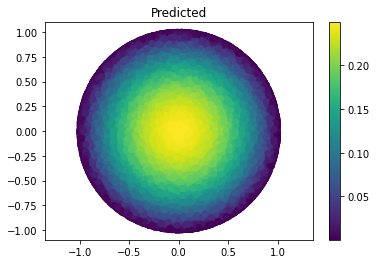

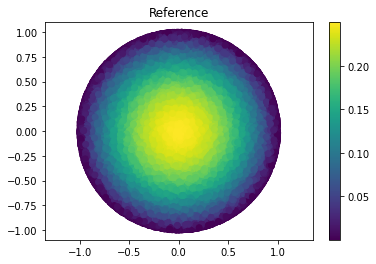

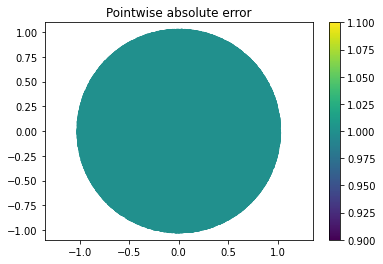

In [10]:
#Validation datapoints
num_val_dat = 100000
xy_val = generate_collocation_points(r, num_val_dat)
u_true = analytical_sol(xy_val)

xy_val = torch.tensor(xy_val, dtype=torch.float32)

u_pred = prediction(model, xy_val)

c_xy = model_c(xy_val)
c_xy = c_xy.detach().cpu().numpy()
c_xy_true = np.ones_like(c_xy)

l2_error = np.linalg.norm(u_pred - u_true)/np.linalg.norm(u_true)
l2_error_cxy = np.linalg.norm(c_xy - c_xy_true)/np.linalg.norm(c_xy_true)


print(f"Relative l2 error in u is: {l2_error*100:0.4f}%")
print(f"Relative l2 error in u is: {l2_error_cxy*100:0.4f}%")

plt.scatter(xy_val[:, 0], xy_val[:, 1], c=u_pred)
plt.title("Predicted")
plt.axis("Equal")
plt.colorbar()
plt.show()

plt.scatter(xy_val[:, 0], xy_val[:, 1], c=u_true)
plt.title("Reference")
plt.axis("Equal")
plt.colorbar()
plt.show()

plt.scatter(xy_val[:, 0], xy_val[:, 1], c=c_xy_true)
plt.title("Pointwise absolute error")
plt.axis("Equal")
plt.colorbar()
plt.show()


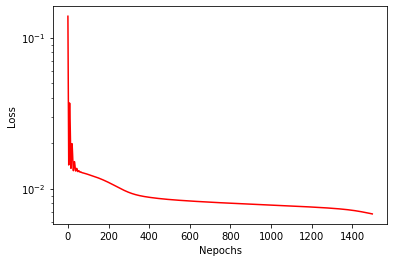

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

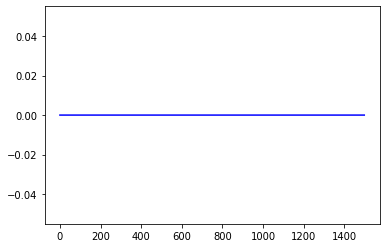

In [35]:
# Plot of convergence of loss and parameters
it = np.arange(0, nIters)
plt.semilogy(it, loss_history, "-r")
plt.xlabel("Nepochs")
plt.ylabel("Loss")
plt.show()
